## Курсовой проект

### Задача:
##### Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.
### Наименование файлов с данными
##### course_project_train.csv - обучающий датасет
##### course_project_test.csv - тестовый датасет
### Описание датасета
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Импорт модулей

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
from scipy.stats import probplot, mannwhitneyu, ttest_rel, boxcox, shapiro, chi2_contingency
    
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.simplefilter('ignore')

### Функции

In [3]:
def hists_descr(feature, bins = 60, log_x = False, log_y = False, grid = False):
    """
    Строит гистограмму и кривую распределения по признаку
    """
    matplotlib.rcParams.update({'font.size' : 8})
    sns.set(rc={"figure.figsize": (12, 4)})
    plt.figure(figsize=(24,6))
    plt.subplot(121)
    feature.hist(bins=bins)
    plt.ylabel('Кол-во наблюдений')
    if log_x:
        plt.xscale(value = 'log')
    if log_y:
        plt.yscale(value = 'log')
    
    plt.subplot(122)
    ax1 = sns.distplot(feature)
    if log_x:
        ax1.set_xscale('log')
    if log_y:
        ax1.set_yscale('log')
    plt.show()
    

def box(num_feature,cat_feature, log_x = False, log_y = False):
    """
    Строит boxplot признака в разрезе целевой переменной
    """
    matplotlib.rcParams.update({'font.size' : 8})
    sns.set(rc={"figure.figsize": (10, 12)})
    target = train_df['Credit Default']
    temp = train_df[f'{cat_feature}'].astype('category')
    sns.boxplot(x = f'{num_feature}', y = temp, hue = target, data = train_df, orient = 'h', palette = 'Set1')
    
def cat_plot(data,feature,x = False, y = False, log_y = False, log_x = False):
    """
    Строит график распределения категориальных признаков в разрезе целевой переменной
    """
    sns.set(rc={"figure.figsize": (12, 4)})
    if x:
        ax = sns.countplot(x = feature, hue = 'Credit Default', data = data)
    if y:
        ax = sns.countplot(y = feature, hue = 'Credit Default', data = data)
    plt.ylabel('Кол-во')
    if log_y:
        ax.set_yscale('log')
    if log_x:
        ax.set_xscale('log')
    plt.show()
    
def plot_kde_qq_interval(data, feature):
    """
    Строит график плотности для признака в разрезе целевой переменной,
    qq диаграмму признака и доверительные интервалы в разрезе целевой переменной
    """
    
    sns.set(rc={"figure.figsize": (18, 12)})
    
    plt.subplot(221)
    sns.kdeplot(data[data['Credit Default'] == 1][feature],label='Погашен', color='green')
    sns.kdeplot(data[data['Credit Default'] == 0][feature],label='Просрочен', color='red')
    plt.xlabel(feature)
    plt.ylabel('Плотность распределения')
    plt.title(f'Распределение {feature} в разрезе целевой переменной')
    
    plt.subplot(222)
    probplot(data[feature].sample(1000), dist='norm', plot=plt)
    plt.title(f'QQ-диаграмма {feature}')
    plt.subplot(223)
    sns.pointplot(x='Credit Default', y=feature, data=data, capsize = .1)
    plt.title(f'Доверительные интервалы {feature}')
    
    plt.show()
    
def plot_qq(data,feature):
    """
    Строит ТОЛЬКО QQ-диаграмму по признаку
    """
    sns.set(rc={"figure.figsize": (10, 6)})
    probplot(data[feature].sample(1000), plot=plt)
    plt.title(f'QQ-диаграмма {feature}')
    plt.show()
    
    
def shapiro_samples(data, feature, samples_num, bxc = False):
    """
    Проверка распределения на нормальность по критерию Шапиро-Уилка с мощностью семплов 1000
    + обратное преобразование boxcox
    """
    shapiro_l = []
    boxcox_l = []
    for i in range(samples_num):
        spl = data[feature].sample(1000)
        c,p = shapiro(spl)
        shapiro_l.append(p)
        
        if bxc:
            x, y = boxcox(spl)
            c, p = shapiro(x)
            boxcox_l.append(p)
    
    if bxc:
        print(f'Среднее P-value по Shapiro с обратным преобразованием: {sum(boxcox_l)/len(boxcox_l)}')
        print(f'Среднее P-value по Shapiro без обратного преобразования: {sum(shapiro_l)/len(shapiro_l)}')
        print('Установленный нами порог α = 0,05')
    if not bxc:
        print(f'Среднее P-value по Shapiro: {sum(shapiro_l)/len(shapiro_l)}')
        print('Установленный нами порог α = 0,05')
        
def t_student(data, feature, samples_num):
    """
    Нахождение среднего p-value по t-критерию с мощностью семплов 1000
    """

    t_list = []
    for i in range(samples_num):
        spl_0 = data[data['Credit Default']==0][feature].sample(1000)
        spl_1 = data[data['Credit Default']==1][feature].sample(1000)
        
        c,p = ttest_rel(spl_0, spl_1)
        t_list.append(p)
        
    print(f'Среднее p-value по t-критерию Стьюдента равно: {sum(t_list)/len(t_list)}')
    print('Установленный нами порог α = 0,05')
    
    
def manna_uitny(data, feature, samples_num):
    """
    Нахождение среднего p-value по критерию Манна-Уитни с мощностью семплов 1000
    """

    m_list = []
    for i in range(samples_num):
        spl_0 = data[data['Credit Default']==0][feature].sample(1000)
        spl_1 = data[data['Credit Default']==1][feature].sample(1000)
        
        c,p = mannwhitneyu(spl_0, spl_1)
        m_list.append(p)
        
    print(f'Среднее p-value по критерию Манна-Уитни равно: {sum(m_list)/len(m_list)}')
    print('Установленный нами порог α = 0,05')
    
    
def chi2_cat_to_cat(data, feature, samples_num, all_info = False, interest_info = False):
    
    categories_list_1 = data[feature].unique().tolist()
    categories_list_copy = categories_list_1
    for cat_1 in categories_list_1:
        for cat_2 in categories_list_copy:
            if cat_1 != cat_2:
                
                c_list = []
                p_list = []
                for i in range(samples_num):
                    
                    count_values = data.loc[data[feature] == cat_1, feature].count() + \
                    data.loc[data[feature] == cat_2, feature].count()
                    
                    if count_values < 400:
                        power = count_values
                    else:
                        power = 400
                    
                    spl = data.loc[data[feature].isin([cat_1,cat_2]),['Id',feature,'Credit Default']].sample(power)
                    table = spl.pivot_table(values = 'Id', index = feature, columns = 'Credit Default', aggfunc = 'count')
                    chi2, p, dof, expected = chi2_contingency(table, correction = False)
                    if not np.isnan(chi2):
                        c_list.append(chi2)
                        p_list.append(p)

                if all_info:
                    print(f'{cat_1}    -    {cat_2}')
                    try:
                        c_mean = sum(c_list)/len(c_list)
                        print(f'Среднее chi2 равно: {c_mean}\n' 
                              f'Среднее p-value равно: {sum(p_list)/len(p_list)}')
                        print('Установленный нами порог α = 0,05')
                        print('-'*43)
                    except:
                        print('Недостаточно данных')
                        print('-'*43)
                   
                if interest_info:
                    print('-'*43)
                    print(f'{cat_1}    -    {cat_2}')
                    try:
                        c_mean = sum(c_list)/len(c_list)
                        if c_mean < 0.05:
                            print(f'Среднее chi2 равно: {c_mean}\n' 
                                  f'Среднее p-value равно: {sum(p_list)/len(p_list)}')
                            print('Установленный нами порог α = 0,05')
                            print('-'*43)
                    except:
                        print('Недостаточно данных')
                        print('-'*43)

### Преобразование дата, добавление столбца Id

In [4]:
train_df = pd.read_csv('course_project_train.csv')
train_df['Id'] = train_df.index.tolist()

## 1.Анализ данных

In [5]:
train_df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  Id  
0                 47386.0        7914.0         749.0               0   0  
1                394972.0       18373.0         737.0               1   1  
2                308389.0       13651.0         742.0               0   2  
3                 95855.0       11338.0         694.0               0   3  
4                 93309.0        7180.0         719.0               0   4

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
train_df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default           Id  
count   5943.000000     7500.000000  7500.000000  
mean    1151.087498        0.281733  3749.500000  
std     1604.451418        0.449874  2165.207842  
min      585.000000        0.000000     0.000000  
25%      711.000000        0.000000  1874.750000  
50%      731.000000        0.000000  3749.500000  
75%      743.000000        1.000000  5624.250000  
max     7510.000000        1.000000  7499.000000

###  Анализ целевой переменной - Credit Default

In [8]:
# train_df['Credit Default'].isnull().value_counts() # пропусков нет
# train_df[(train_df['Credit Default'] > 1) | (train_df['Credit Default'] < 0)] 
# Целевая переменная не имеет аномальных значений
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Видим, что кол-во выполнения кредитных обязательств значительно превышает кол-во невыполнения

## 2.Предварительный анализ количественных данных и заполнение пропусков

### 2.1.Annual Income

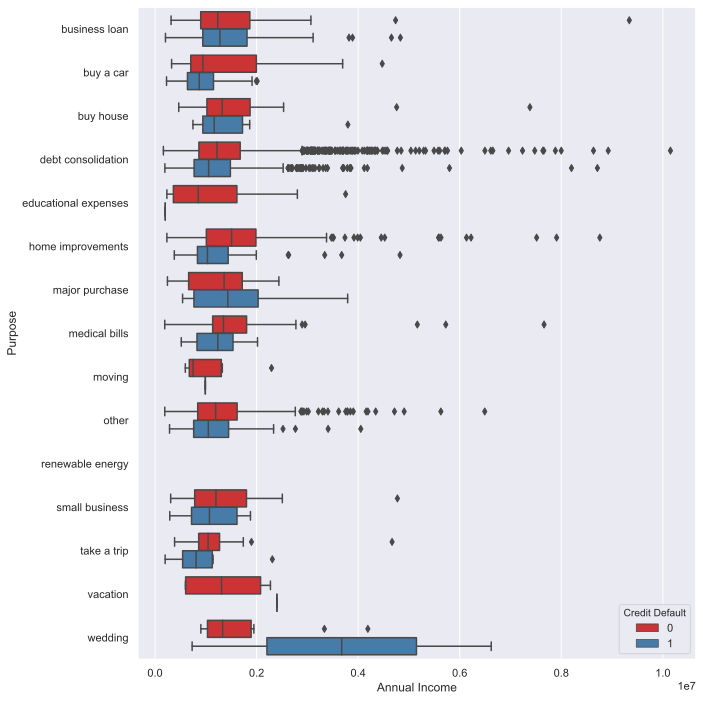

In [9]:
box('Annual Income','Purpose')

Интересная ситуация со свадьбами. С увеличением годового дохода растут просрочки. Забавно)

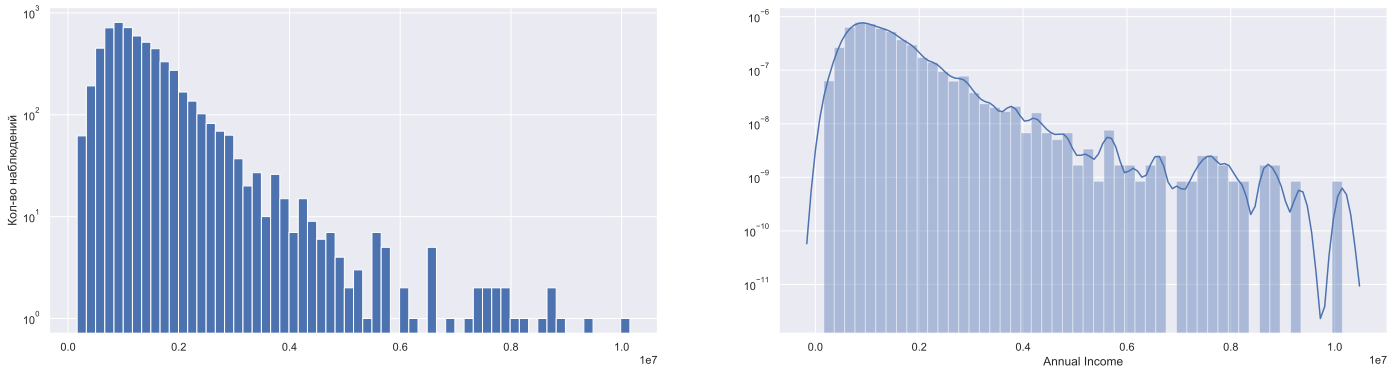

In [10]:
hists_descr(train_df['Annual Income'],log_y = True)

Видим, что объектам с доходом больше 8000000 у.е. понадобилось кредитование,это вполне нормально, но посмотрим на цель кредита.

In [11]:
train_df[train_df['Annual Income'] > 8000000]

Home Ownership  Annual Income Years in current job  Tax Liens  \
1025           Rent      8923844.0              3 years        0.0   
1984  Home Mortgage      8758449.0            10+ years        0.0   
2200           Rent      9338880.0            10+ years        0.0   
2474  Home Mortgage      8633790.0              2 years        0.0   
4491  Home Mortgage      8200229.0              2 years        0.0   
5396  Home Mortgage      8710740.0              2 years        2.0   
6472           Rent     10149344.0              5 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
1025                     15.0                     17.2            1452000.0   
1984                     10.0                     20.6                  0.0   
2200                      7.0                      7.3            1092608.0   
2474                     13.0                     15.6            1091200.0   
4491                     11.0                     16.7             333630.0   
5396                     15.0                     16.5            3162896.0   
6472                     10.0                     17.5             270380.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
1025                        0.0                           NaN           0.0   
1984                        0.0                           NaN           0.0   
2200                        0.0                           NaN           0.0   
2474                        0.0                          36.0           0.0   
4491                        0.0                          29.0           0.0   
5396                        2.0                           NaN           0.0   
6472                        0.0                          22.0           0.0   

                 Purpose        Term  Current Loan Amount  \
1025  debt consolidation  Short Term             670428.0   
1984   home improvements  Short Term           99999999.0   
2200       business loan  Short Term             788480.0   
2474  debt consolidation   Long Term             777546.0   
4491  debt consolidation  Short Term             117040.0   
5396  debt consolidation  Short Term             560340.0   
6472  debt consolidation  Short Term             664818.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default    Id  
1025               1084710.0       62095.0         723.0               0  1025  
1984               2759503.0       12919.0         748.0               0  1984  
2200                326496.0       40546.0         720.0               0  2200  
2474                765244.0       25038.0         679.0               0  2474  
4491                116128.0        8610.0        7440.0               1  4491  
5396               1663545.0       40215.0         735.0               1  5396  
6472                205713.0       61235.0         692.0               0  6472

##### Аномалии:
* Объект 1984 взял кредит(имея ипотеку, или на ипотеку) на 99999999 у.е. с ежемесячным платежом 12919 у.е. - выброс.
* Объект 6472 с доходом 10149344 у.е. имеет максимально открытый кредит в 270380 у.е. - выброс.
###### Эти выбросы я удалю, а вот к объекту 4491 вернемся при анализе Credit Score(7440)

In [12]:
train_df = train_df.drop([1984, 6472], axis = 0)

###### Ищем пропущенные значения

In [13]:
train_df['Annual Income'].isnull().value_counts()

False    5941
True     1557
Name: Annual Income, dtype: int64

Очень много пропусков для такой маленькой выборки,даже при замене это сильно влияет на модель.Считаю оптимальным заменить пропуски медиальным значение дохода по каждой цели кредита

In [14]:
train_df['Purpose'].value_counts()

debt consolidation      5943
other                    665
home improvements        411
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Замена пропусков медиальным значением по цели кредита

In [15]:
purposes = train_df['Purpose'].value_counts().index.to_list()
for i in purposes:
    temp = train_df.loc[train_df['Purpose'] == i, 'Annual Income']
    train_df.loc[train_df['Annual Income'].isnull() & (train_df['Purpose'] == i), 'Annual Income'] = temp.median()
    if np.isnan(temp.median()):
        train_df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].median()

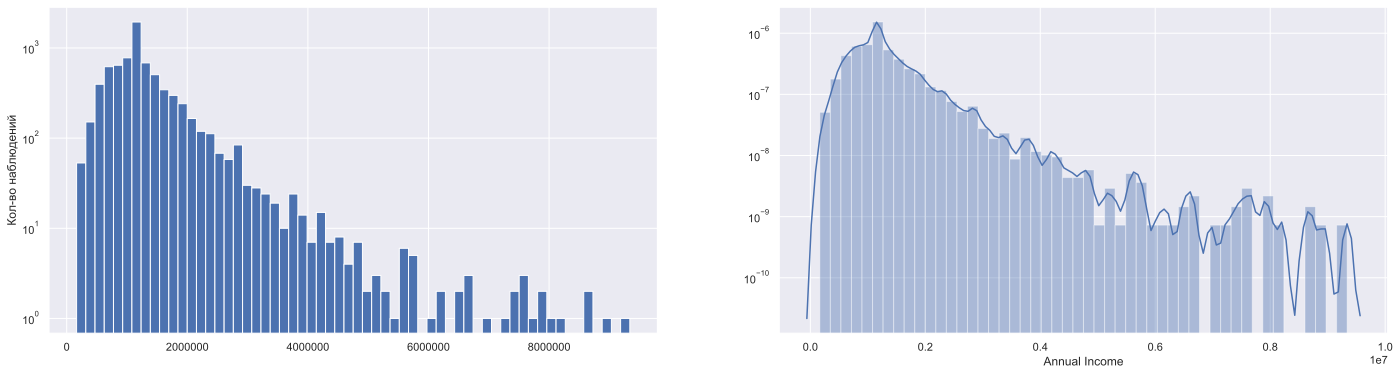

In [16]:
hists_descr(train_df['Annual Income'],log_y = True)

### 2.2.Tax Liens

In [17]:
train_df['Tax Liens'].isnull().value_counts() # пропусков нет
train_df['Tax Liens'].value_counts()

0.0    7364
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

### 2.3.Number of Open Accounts

In [18]:
train_df['Number of Open Accounts'].isnull().value_counts() # пропусков нет
train_df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    675
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

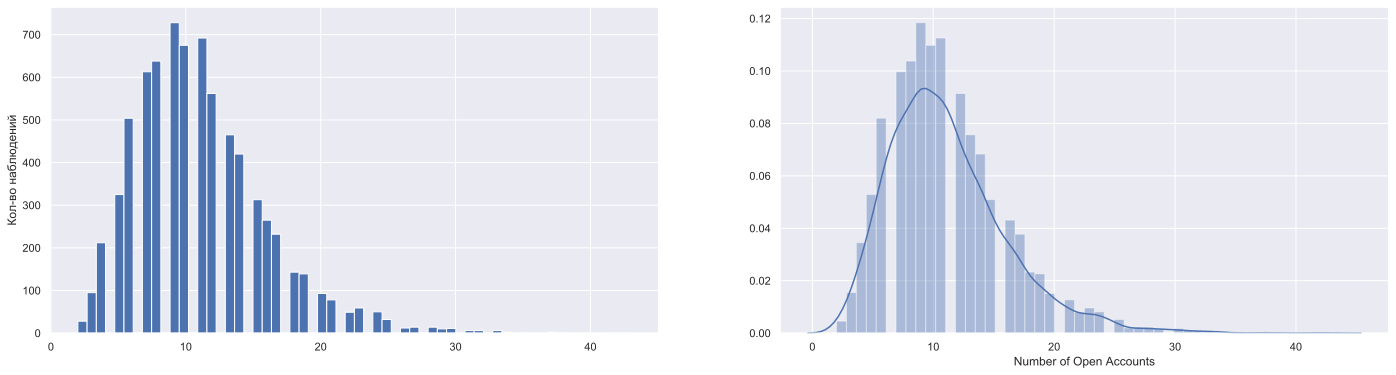

In [19]:
hists_descr(train_df['Number of Open Accounts'])

### 2.4.Years of Credit History

Пропусков нет, аномальных значений нет

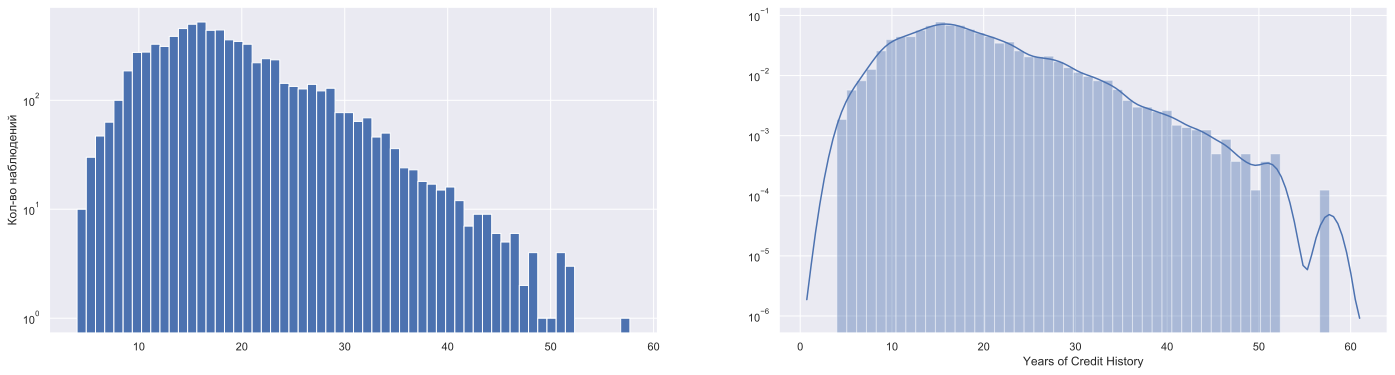

In [20]:
hists_descr(train_df['Years of Credit History'], log_y=True)

### 2.5.Number of Credit Problems

In [21]:
train_df['Number of Credit Problems'].isnull().value_counts() # пропусков нет
train_df['Number of Credit Problems'].value_counts()

0.0    6467
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

### 2.6.Maximum Open Credit

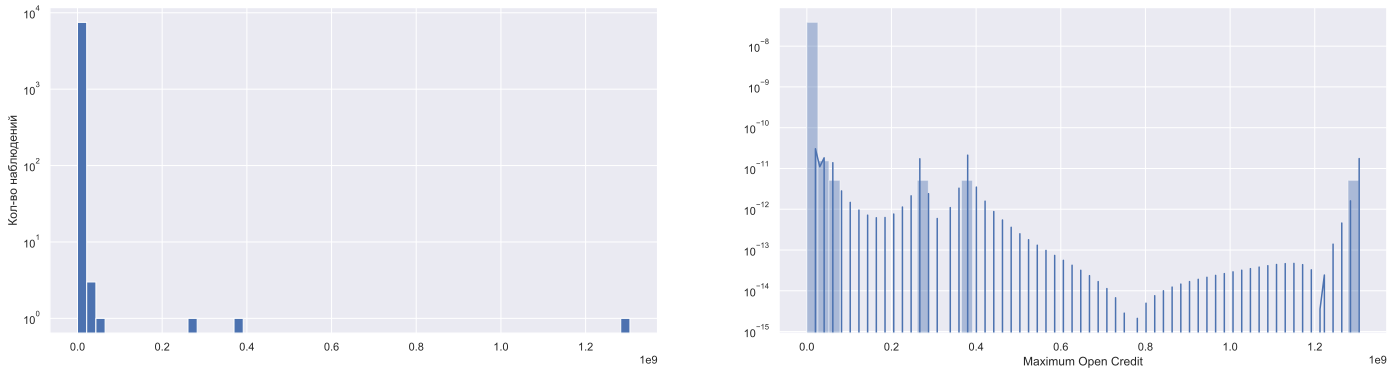

In [22]:
hists_descr(train_df['Maximum Open Credit'], log_y = True)

In [23]:
len(train_df[train_df['Maximum Open Credit'] == 0])

64

64 пропущенных значения. Попробуем подставить Current Loan Amount

In [24]:
train_df.loc[train_df['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = \
train_df.loc[train_df['Maximum Open Credit'] == 0, 'Current Loan Amount']

Также на графике видим несколько аномально высоких значений

In [25]:
#train_df[train_df['Maximum Open Credit'] > 99999990].head(4)
len(train_df[train_df['Maximum Open Credit'] > 9000000])

32

Много, вносят сильные искажения.Давайте примем эти ситуации за рефинансирование и тоже приравняем к  Current Loan Amount

In [26]:
train_df.loc[train_df['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
train_df.loc[train_df['Maximum Open Credit'] > 9000000, 'Current Loan Amount']

Посмотрим на распределение

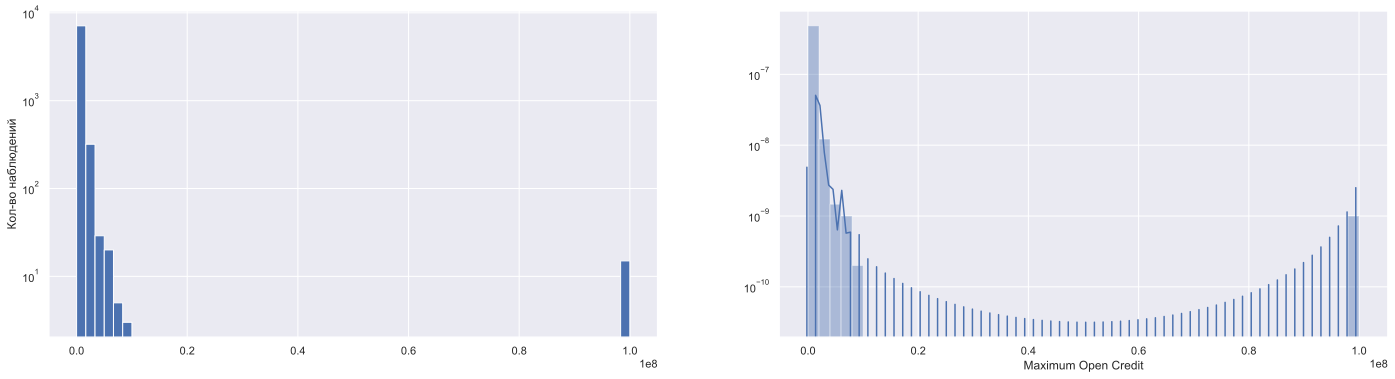

In [27]:
hists_descr(train_df['Maximum Open Credit'], log_y = True)

Снова аномалия,это выбросы в Current Loan Amount, тогда оставшиеся заменим на Current Credit Balance

In [28]:
train_df.loc[train_df['Maximum Open Credit'] > 9000000, 'Maximum Open Credit'] = \
train_df.loc[train_df['Maximum Open Credit'] > 9000000, 'Current Credit Balance']

Смотрим на распределение

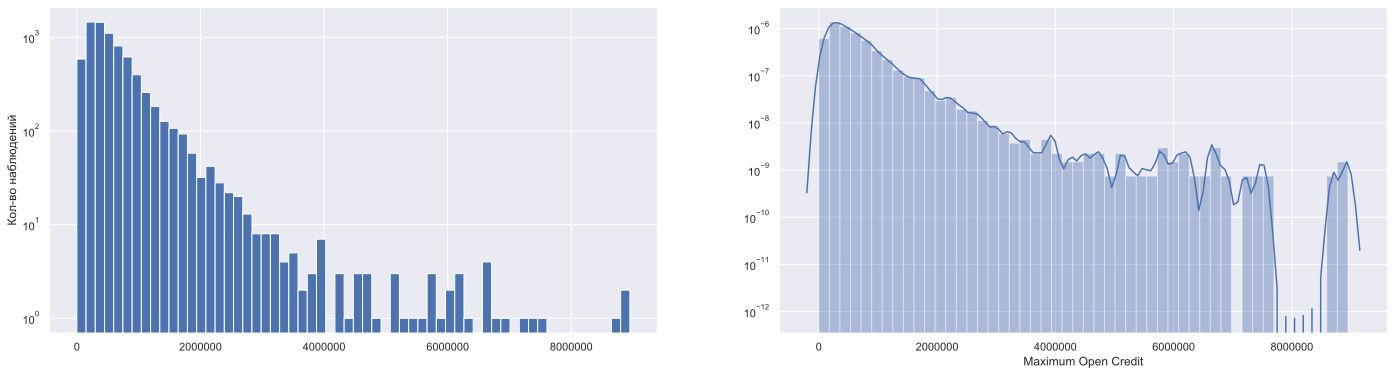

In [29]:
hists_descr(train_df['Maximum Open Credit'], log_y = True)

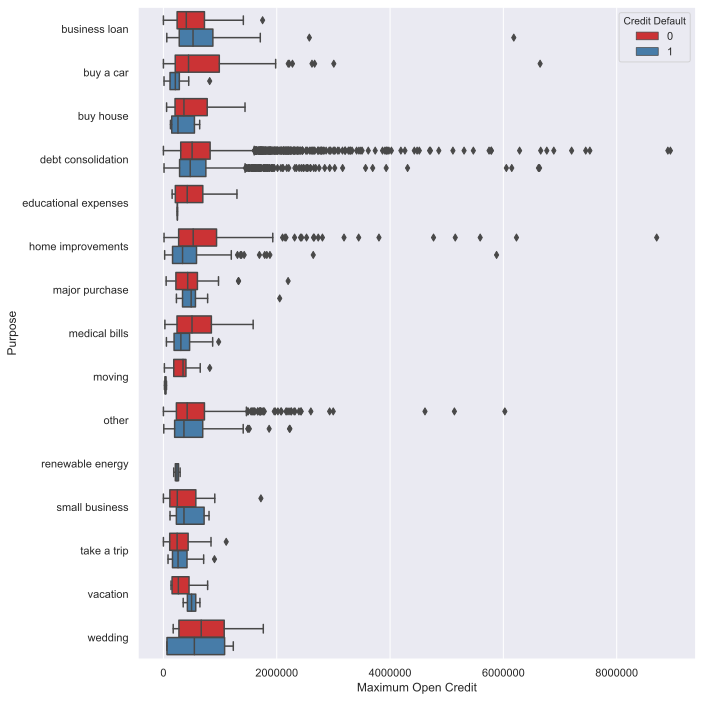

In [30]:
box('Maximum Open Credit','Purpose')

Пока будем считать, что такое распредеделение величины нас устраивает

### 2.7.Months since last delinquent...........UPD(удален)

In [31]:
train_df['Months since last delinquent'].isnull().value_counts()

True     4080
False    3418
Name: Months since last delinquent, dtype: int64

Я не знаю что делать с этим признаком,подчти половина значений пропущенно и он слишком привязан к ситуации конкретного объекта.У меня нет идей как искуственно заменить его. Пока решаю не использовать его при построении модели.

In [32]:
train_df.drop('Months since last delinquent', axis = 1, inplace=True)

### 2.8.Bankruptcies

In [33]:
train_df['Bankruptcies'].isnull().value_counts()

False    7484
True       14
Name: Bankruptcies, dtype: int64

Можно заморочиться и заполнить пропуски в зависимости от других признаков, но их мало и я склоняюсь к замене на нулевую моду.

In [34]:
train_df['Bankruptcies'].mode()[0]

0.0

In [35]:
train_df['Bankruptcies'].fillna(0, inplace=True)

### 2.9.Current Loan Amount

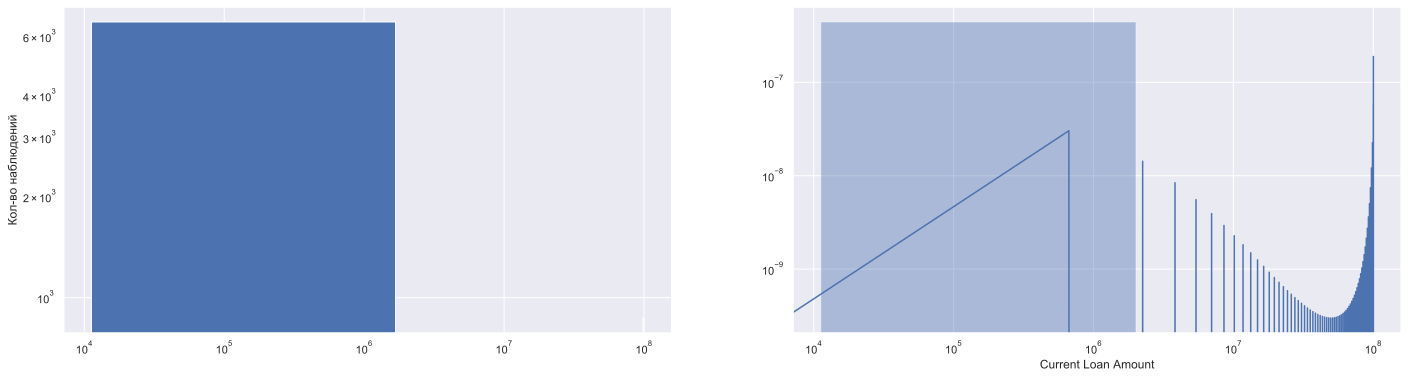

In [36]:
hists_descr(train_df['Current Loan Amount'],log_x=True, log_y=True)

In [37]:
train_df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   7.498000e+03  7498.000000              7498.000000   
mean    1.324667e+06     0.030141                11.131235   
std     7.454741e+05     0.271639                 4.909544   
min     1.645970e+05     0.000000                 2.000000   
25%     9.307008e+05     0.000000                 8.000000   
50%     1.165878e+06     0.000000                10.000000   
75%     1.500316e+06     0.000000                14.000000   
max     9.338880e+06     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7498.000000         7.498000e+03   
mean                 18.317271         6.408164e+05   
std                   7.042829         6.362322e+05   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.802030e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.906250e+05   
max                  57.700000         8.947840e+06   

       Number of Credit Problems  Bankruptcies  Current Loan Amount  \
count                7498.000000   7498.000000         7.498000e+03   
mean                    0.170045      0.116965         1.186292e+07   
std                     0.498657      0.346945         3.191389e+07   
min                     0.000000      0.000000         1.124200e+04   
25%                     0.000000      0.000000         1.801470e+05   
50%                     0.000000      0.000000         3.094960e+05   
75%                     0.000000      0.000000         5.194750e+05   
max                     7.000000      4.000000         1.000000e+08   

       Current Credit Balance   Monthly Debt  Credit Score  Credit Default  \
count            7.498000e+03    7498.000000   5941.000000     7498.000000   
mean             2.895151e+05   18309.449453   1151.232621        0.281808   
std              3.166300e+05   11917.887145   1604.701920        0.449911   
min              0.000000e+00       0.000000    585.000000        0.000000   
25%              1.142375e+05   10066.500000    711.000000        0.000000   
50%              2.093230e+05   16076.500000    731.000000        0.000000   
75%              3.603112e+05   23811.500000    743.000000        1.000000   
max              6.506797e+06  136679.000000   7510.000000        1.000000   

                Id  
count  7498.000000  
mean   3749.372366  
std    2165.172331  
min       0.000000  
25%    1874.250000  
50%    3749.500000  
75%    5623.750000  
max    7499.000000

In [38]:
# len(train_df[train_df['Current Loan Amount'] >= 99999999])   -    869 значений, много
train_df[train_df['Current Loan Amount'] >= 99999999]

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0                  NaN        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
6     Home Mortgage      1511108.0            10+ years        0.0   
22             Rent       463790.0                  NaN        0.0   
27             Rent      1004055.0              8 years        0.0   
...             ...            ...                  ...        ...   
7441           Rent      1406836.0               1 year        0.0   
7445  Home Mortgage      1564384.0              6 years        0.0   
7464  Home Mortgage      1159152.0              6 years        0.0   
7475           Rent       848426.0            10+ years        0.0   
7497           Rent      1878910.0              6 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     26.3             685960.0   
2                        11.0                     35.0            1182434.0   
6                         9.0                     20.3             388124.0   
22                        6.0                     28.3             288442.0   
27                        7.0                     14.5             328394.0   
...                       ...                      ...                  ...   
7441                     12.0                     22.6            2383260.0   
7445                     21.0                     17.3            1545016.0   
7464                     14.0                     22.0             389356.0   
7475                      8.0                     20.1             526306.0   
7497                     12.0                     32.1            1778920.0   

      Number of Credit Problems  Bankruptcies             Purpose        Term  \
0                           1.0           1.0  debt consolidation  Short Term   
2                           0.0           0.0  debt consolidation  Short Term   
6                           0.0           0.0   home improvements  Short Term   
22                          0.0           0.0  debt consolidation  Short Term   
27                          0.0           0.0  debt consolidation  Short Term   
...                         ...           ...                 ...         ...   
7441                        0.0           0.0  debt consolidation  Short Term   
7445                        0.0           0.0               other   Long Term   
7464                        1.0           1.0  debt consolidation  Short Term   
7475                        0.0           0.0  debt consolidation  Short Term   
7497                        0.0           0.0           buy a car  Short Term   

      Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  \
0              99999999.0                 47386.0        7914.0         749.0   
2              99999999.0                308389.0       13651.0         742.0   
6              99999999.0                 51623.0        2317.0         745.0   
22             99999999.0                157700.0        5063.0         738.0   
27             99999999.0                195966.0        6041.0         734.0   
...                   ...                     ...           ...           ...   
7441           99999999.0                461054.0        7386.0         747.0   
7445           99999999.0               1043442.0       32461.0         728.0   
7464           99999999.0                 49438.0       18257.0         737.0   
7475           99999999.0                 83638.0       16473.0         742.0   
7497           99999999.0                477812.0       12479.0         748.0   

      Credit Default    Id  
0                  0     0  
2                  0     2  
6                  0     6  
22                 0    22  
27                 0    27  
...              ...   ...  
7441               0  7441  
7445               0  7445  
7464    

Попробую заменить на Maximum Open Credit

In [39]:
train_df.loc[train_df['Current Loan Amount'] >=99999999, 'Current Loan Amount' ] = \
train_df.loc[train_df['Current Loan Amount'] >=99999999, 'Maximum Open Credit']

Посмотрим, что получилось

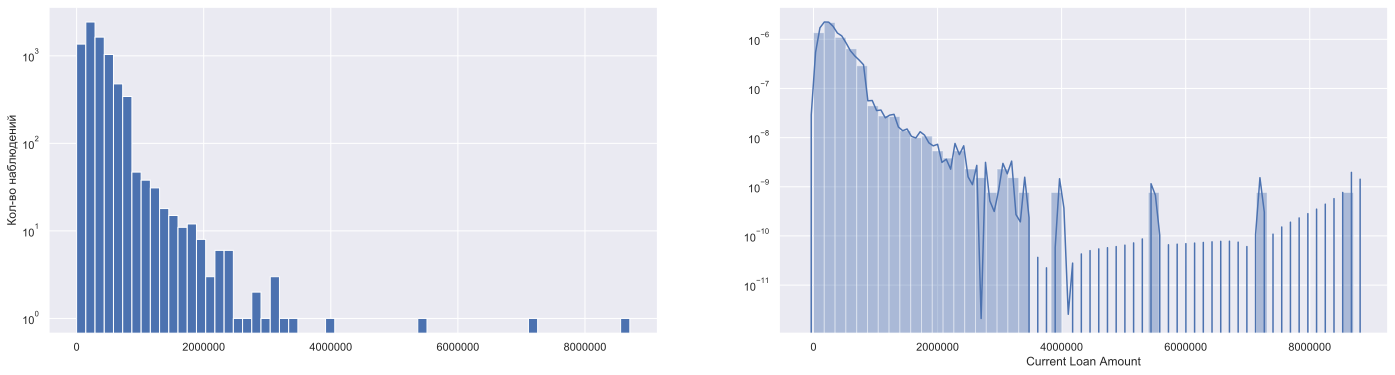

In [40]:
hists_descr(train_df['Current Loan Amount'], log_y=True)

Распределение стало похожим на Maximum Open Credit, что неудивительно, ведь я искуственно увеличил корреляцию между этими признаками путем взаимной подмены значений.В дальнейшем посмотрим на матрицу корреляций.

### 2.10.Current Credit Balance

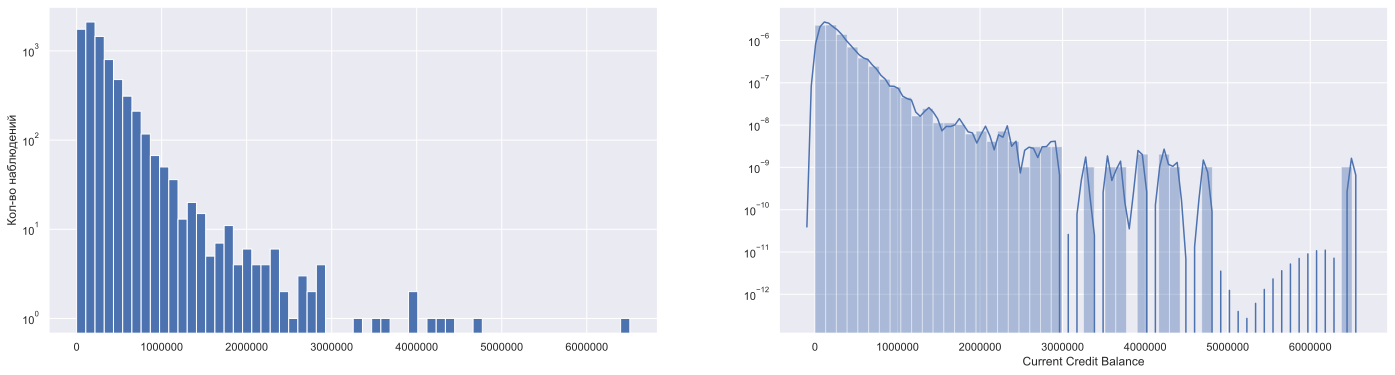

In [41]:
hists_descr(train_df['Current Credit Balance'], log_y=True)

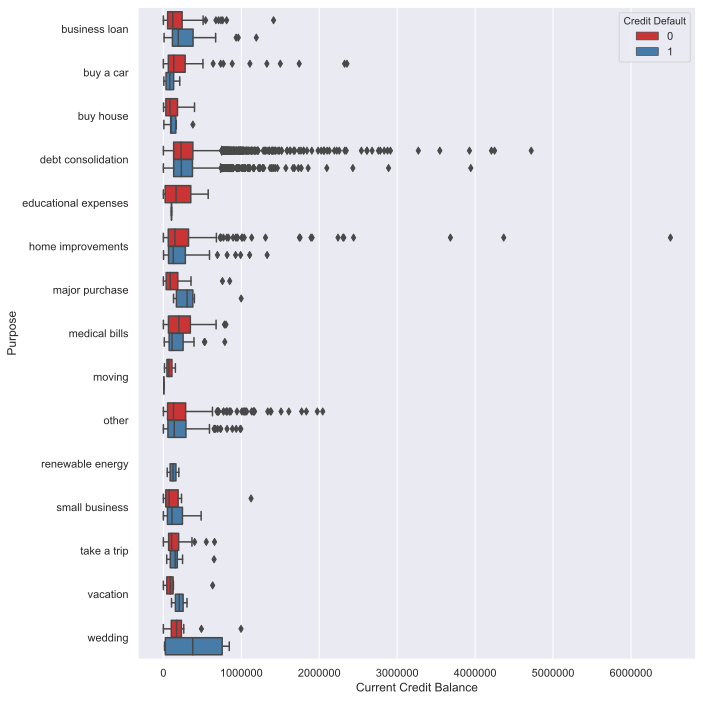

In [42]:
box('Current Credit Balance','Purpose')

Вижу значение > 6000000 с причиной "улучшение жилищных условий". Посмотрим на данный объект

In [43]:
train_df[train_df['Current Credit Balance'] > 6000000]

Home Ownership  Annual Income Years in current job  Tax Liens  \
4769  Home Mortgage      3739960.0              9 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
4769                      7.0                     22.8             757834.0   

      Number of Credit Problems  Bankruptcies            Purpose        Term  \
4769                        0.0           0.0  home improvements  Short Term   

      Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  \
4769             757834.0               6506797.0       38023.0         703.0   

      Credit Default    Id  
4769               0  4769

Объект с годовым доходом в 3739960 у.е.,22 летней кредитной историей, 0 проблем с кредитом и при этом имея кредитный скоринг на кровне 700—720 — «плохо» берет рефинансирование ипотеки в размере 757834 у.е. с кредитным балансом 6506797 у.е.  Я возможно не правильно понимаю определение кредитного баланса, но сама ситуация выглядит странной. Удалю этот объект

In [44]:
train_df.drop(4769, axis = 0, inplace=True)

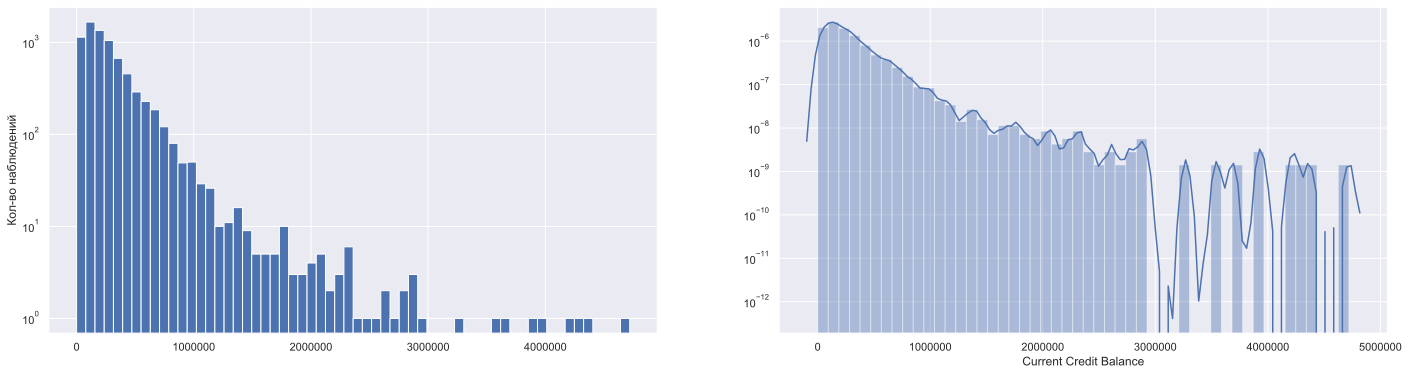

In [45]:
hists_descr(train_df['Current Credit Balance'], log_y=True)

### 2.11.Monthly Debt

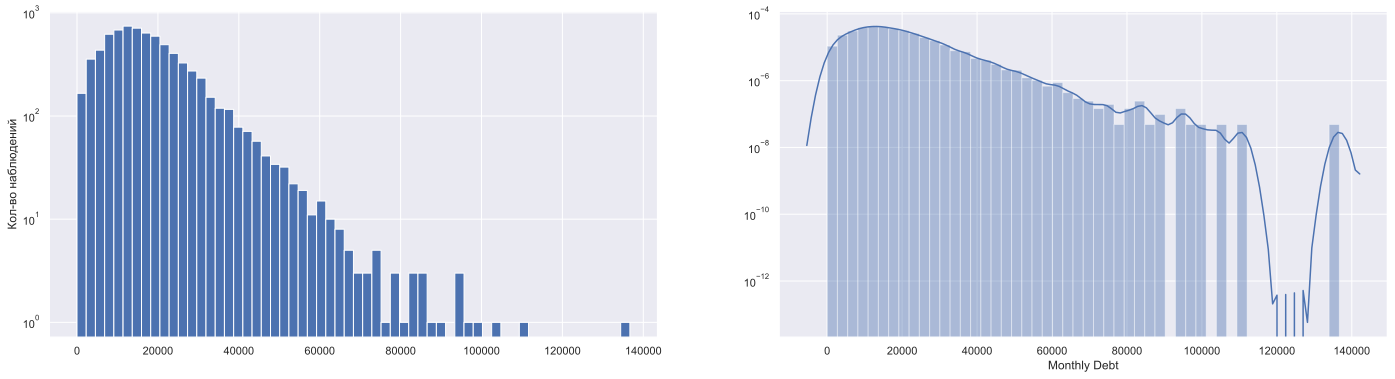

In [46]:
hists_descr(train_df['Monthly Debt'], log_y=True)

### 2.12 Credit Score

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             7497 non-null   object 
 1   Annual Income              7497 non-null   float64
 2   Years in current job       7126 non-null   object 
 3   Tax Liens                  7497 non-null   float64
 4   Number of Open Accounts    7497 non-null   float64
 5   Years of Credit History    7497 non-null   float64
 6   Maximum Open Credit        7497 non-null   float64
 7   Number of Credit Problems  7497 non-null   float64
 8   Bankruptcies               7497 non-null   float64
 9   Purpose                    7497 non-null   object 
 10  Term                       7497 non-null   object 
 11  Current Loan Amount        7497 non-null   float64
 12  Current Credit Balance     7497 non-null   float64
 13  Monthly Debt               7497 non-null   float

In [48]:
train_df['Credit Score'].isnull().value_counts()

False    5940
True     1557
Name: Credit Score, dtype: int64

In [49]:
train_df[train_df['Credit Score'] > 1000]

Home Ownership  Annual Income Years in current job  Tax Liens  \
69    Home Mortgage      1408527.0              2 years        0.0   
87    Home Mortgage      1533566.0              7 years        0.0   
94             Rent      1049294.0              3 years        0.0   
96             Rent       757568.0              5 years        0.0   
116   Home Mortgage      1039984.0                  NaN        0.0   
...             ...            ...                  ...        ...   
7422           Rent       694868.0               1 year        0.0   
7433           Rent      2011758.0             < 1 year        0.0   
7450  Home Mortgage      1432277.0            10+ years        0.0   
7460           Rent       769462.0              5 years        0.0   
7496  Home Mortgage      1533984.0               1 year        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
69                       12.0                     17.5             700062.0   
87                       11.0                     14.8             715462.0   
94                        5.0                      6.1             249810.0   
96                       13.0                     11.4             383548.0   
116                      10.0                     23.8             147950.0   
...                       ...                      ...                  ...   
7422                      4.0                      7.8             143066.0   
7433                      4.0                     14.9              22176.0   
7450                     16.0                     22.8             825176.0   
7460                      8.0                     17.0             313786.0   
7496                     10.0                     26.5             686312.0   

      Number of Credit Problems  Bankruptcies             Purpose        Term  \
69                          0.0           0.0               other   Long Term   
87                          0.0           0.0  debt consolidation  Short Term   
94                          0.0           0.0       business loan  Short Term   
96                          0.0           0.0  debt consolidation  Short Term   
116                         0.0           0.0  debt consolidation  Short Term   
...                         ...           ...                 ...         ...   
7422                        0.0           0.0  debt consolidation   Long Term   
7433                        0.0           0.0           buy a car   Long Term   
7450                        0.0           0.0  debt consolidation  Short Term   
7460                        0.0           0.0  debt consolidation  Short Term   
7496                        0.0           0.0  debt consolidation   Long Term   

      Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  \
69               525998.0                174135.0        9320.0        6470.0   
87               210826.0                285475.0       18147.0        7440.0   
94               337502.0                119529.0       15215.0        7010.0   
96               210518.0                276583.0       11553.0        7320.0   
116              224246.0                 95456.0       13780.0        7390.0   
...                   ...                     ...           ...           ...   
7422             244178.0                122075.0        4268.0        6690.0   
7433             106480.0                 18791.0       12590.0        6060.0   
7450             187924.0                458242.0       27094.0        7290.0   
7460             109186.0                 45524.0        4585.0        7470.0   
7496             444048.0                456399.0       12783.0        7410.0   

      Credit Default    Id  
69                 1    69  
87                 1    87  
94                 1    94  
96                 1    96  
116                1   116  
...              ...   ...  
7422               1  7422  
7433               1  7433  
7450    

Допущу, что тут просто ошибка в значениях. Исправим

In [50]:
score_list = train_df['Credit Score'].to_list()
credit_list = []
for i in score_list:
    if i > 1000:
        i = i / 10
        credit_list.append(i)
    else:
        credit_list.append(i)
len(score_list), len(credit_list) 

(7497, 7497)

In [51]:
train_df.drop('Credit Score', axis = 1, inplace=True)
train_df['Credit Score'] = credit_list

Также имеются пропущенные значения. Заполним их медианой(среднее значение Credit Score для Американцев равно 723, медиана в нашем датасете равна 729)

In [52]:
train_df['Credit Score'] = train_df['Credit Score'].fillna(train_df['Credit Score'].median())

In [53]:
train_df['Credit Score'].isnull().value_counts()

False    7497
Name: Credit Score, dtype: int64

Все аномальные значения исправлены, все пропуски заполнены. Посмотрим на распределение

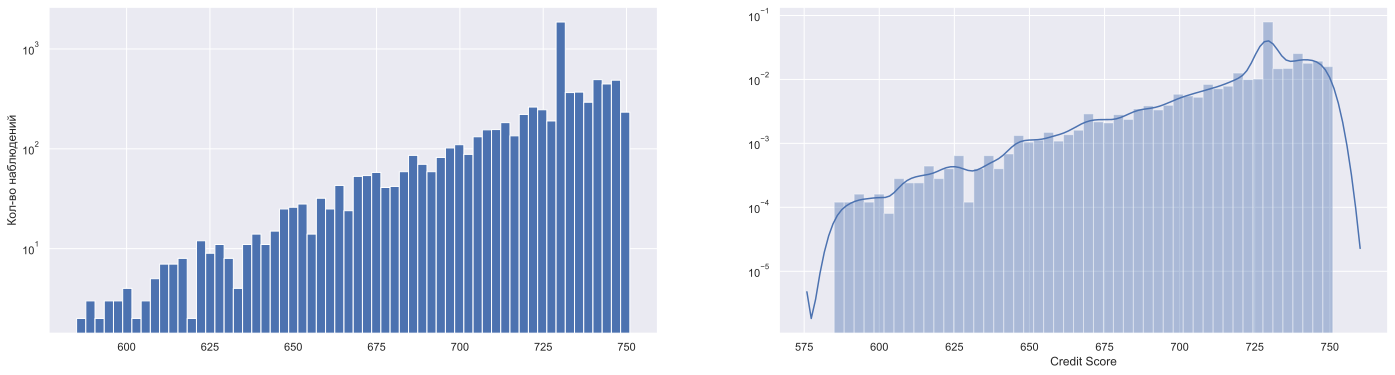

In [54]:
hists_descr(train_df['Credit Score'], log_y=True)

## 3.Предварительный анализ категориальных данных и заполнение пропусков

### 3.1.Home Ownership

In [55]:
train_df['Home Ownership'].isnull().value_counts() # пропусков нет
train_df['Home Ownership'].value_counts()

Home Mortgage    3635
Rent             3203
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

### 3.2.Years in current job

In [56]:
train_df['Years in current job'].isnull().value_counts()

False    7126
True      371
Name: Years in current job, dtype: int64

In [57]:
train_df['Years in current job'].mode()

0    10+ years
dtype: object

Заполним пропуски модой

In [58]:
train_df['Years in current job'].fillna('10+ years', inplace=True)

### 3.3.Purpose

In [59]:
#train_df['Purpose'].isnull().value_counts()
train_df['Purpose'].value_counts()

debt consolidation      5943
other                    665
home improvements        410
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Не знаю, что такое возобновляемая энергия. Может это покрытие крыши поликремниевыми батареями(к примеру), можно тогда заменить на home improvements, но замени на моду - debt consolidation.

In [60]:
train_df.loc[train_df['Purpose'] == 'renewable energy', 'Purpose'] = train_df['Purpose'].mode()
train_df['Purpose'].fillna('debt consolidation', inplace=True)

### 3.4.Term

In [61]:
train_df['Term'].value_counts()

Short Term    5553
Long Term     1944
Name: Term, dtype: int64

Пропусков нет

### Посмотрим на корреляционную матрицу

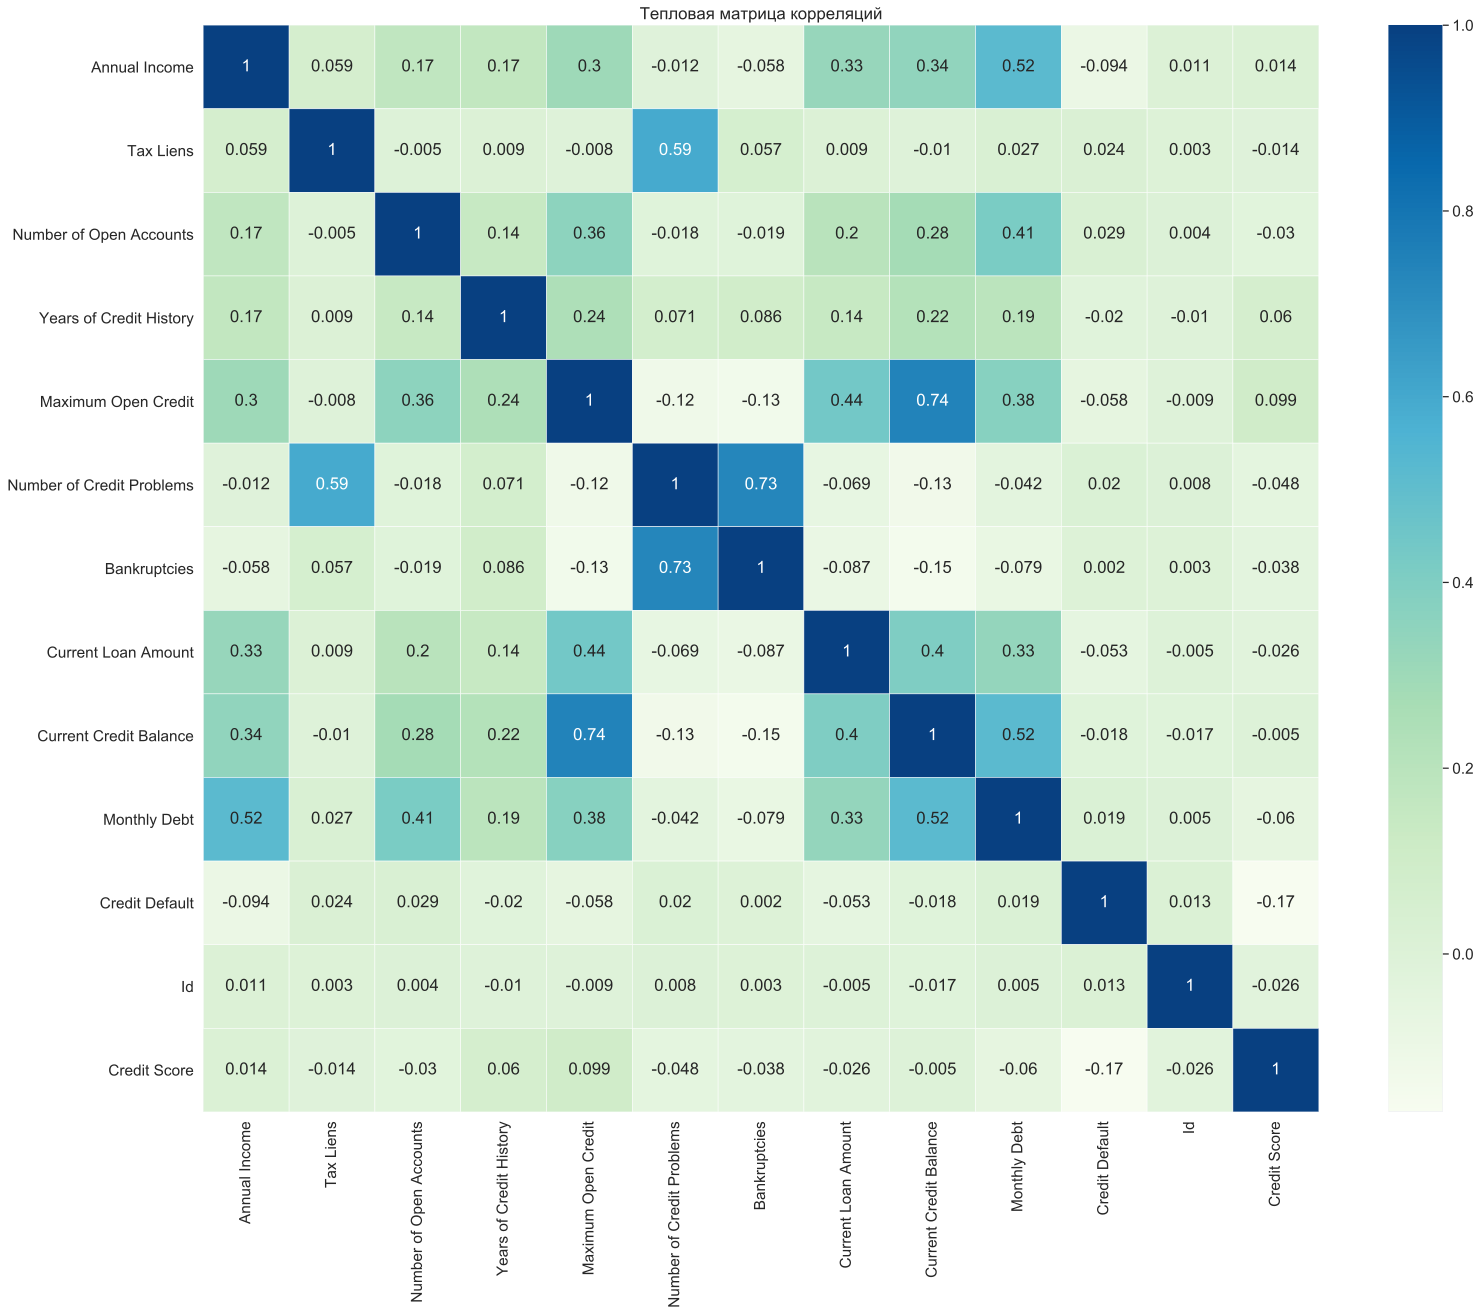

In [62]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(train_df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Тепловая матрица корреляций')
plt.show()

Видим высокую корреляцию между Number of Credit Problems и Bankrupties. При проведении подробного анализа стоит присмотреться к этим признакам

## 4.Подробный анализ количественных данных 

### Я так понимаю, что наша основная задача выявить признаки, которые будут вносить весомый вклад в определение целевой переменной, следовательно формирование гипотез будет не как в уроке(нормальное/не нормальное распределение), а полезный/не полезный признак. 

### Исходить будет из разницы распределений относительно целевой переменной, как визуально, так и при помощи критериев Шапиро-Уилка(нормальность распредедения), t-критерий Стьюдента для двух независимых выборок(проверка равенства средних значений) и непараметрическим U критерием Манна-Уитни(для двух независимых выборок)

### Тогда:
* **Нулевая гипотеза H0** - равенство средних значений по Стьюдента/Манна-Уитни равны
* **Альтернативная гипотеза H1** - средние значения не равны и признак полезен для формирования модели
* **Критерии** - Шапиро-Уилка/t-критерий Стьюдента/Непараметрический критерий Манна-Уинти
* **Порог α** - 0,05

### 4.1 Annual Income

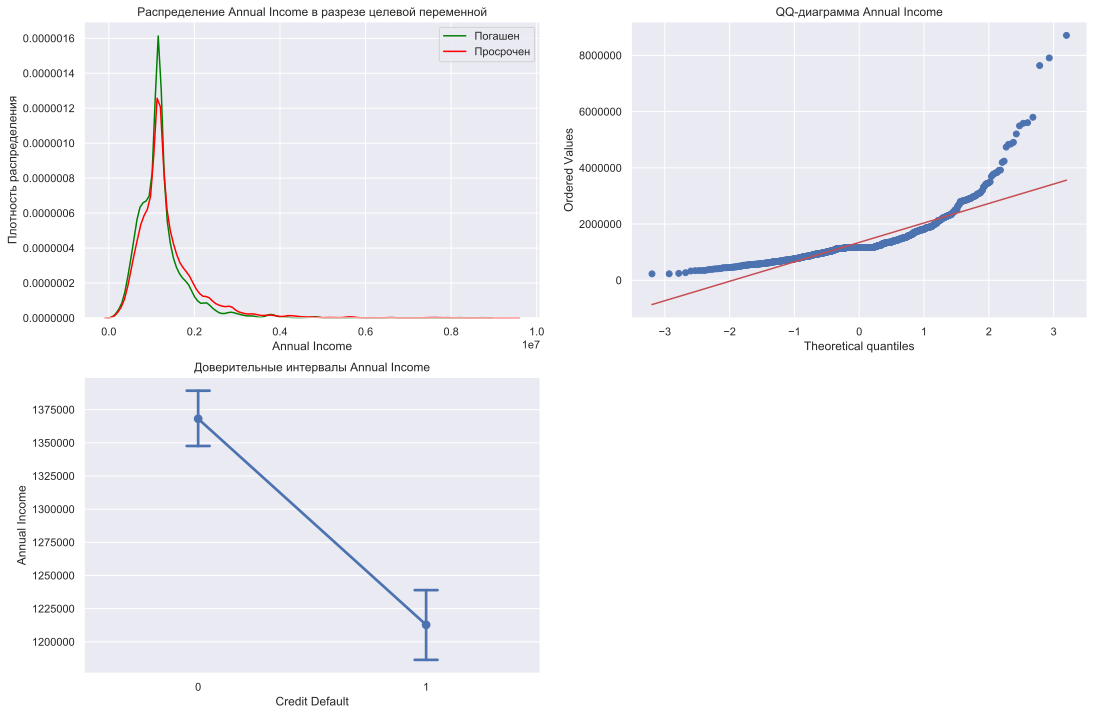

In [63]:
plot_kde_qq_interval(train_df,'Annual Income')

На графиках отчетливо видно, что распределение признака далеко от нормального. НО доверительные интервалы не пересекаются друг с другом, из чего можно предварительно заключить о полезности признака для построения модели. Проведем исследование на нормальность по Шапиро:

In [64]:
shapiro_samples(train_df, 'Annual Income', 30, bxc=True)

Среднее P-value по Shapiro с обратным преобразованием: 6.394004745288879e-11
Среднее P-value по Shapiro без обратного преобразования: 1.105998773717087e-34
Установленный нами порог α = 0,05


Как и ожидалось, распределение далеко от нормального, применим непараметрический U критерий Манна-Уитни для двух независимых выборок

In [65]:
manna_uitny(train_df, 'Annual Income', 30)

Среднее p-value по критерию Манна-Уитни равно: 1.4948142790599721e-05
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза отвергается, мат.ожидания двух выборок не равны**
* **Признак Annual Income полезен для построения модели**

### 4.2 Number of Open Accounts

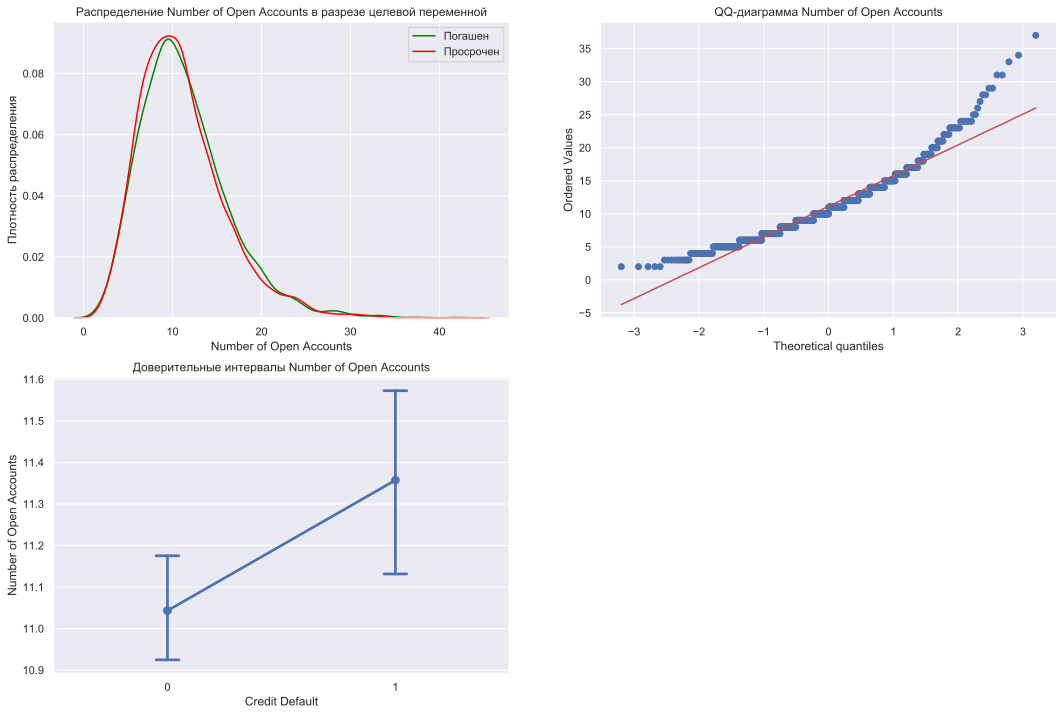

In [66]:
plot_kde_qq_interval(train_df, 'Number of Open Accounts')

Распределение отдаленно похоже на Гауссовское(посмотрм что будет с boxcox). Интервалы совсем немного пересекатся, нулевая и альтернативная гипотезы, как и порог, остаются прежними. Посмотрим на критерий Шапиро-Уилка

In [67]:
shapiro_samples(train_df, 'Number of Open Accounts', 30, bxc=True)

Среднее P-value по Shapiro с обратным преобразованием: 0.0001614261633259654
Среднее P-value по Shapiro без обратного преобразования: 7.779753128002858e-18
Установленный нами порог α = 0,05


Распределение далеко от нормального, применяем критерий Манна-Уитни

In [68]:
manna_uitny(train_df, 'Number of Open Accounts', 30)

Среднее p-value по критерию Манна-Уитни равно: 0.13552529043943154
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза принимается**
* **Признак Number of Open Accounts мало полезен для построения модели**

### 4.3 Years of Credit History

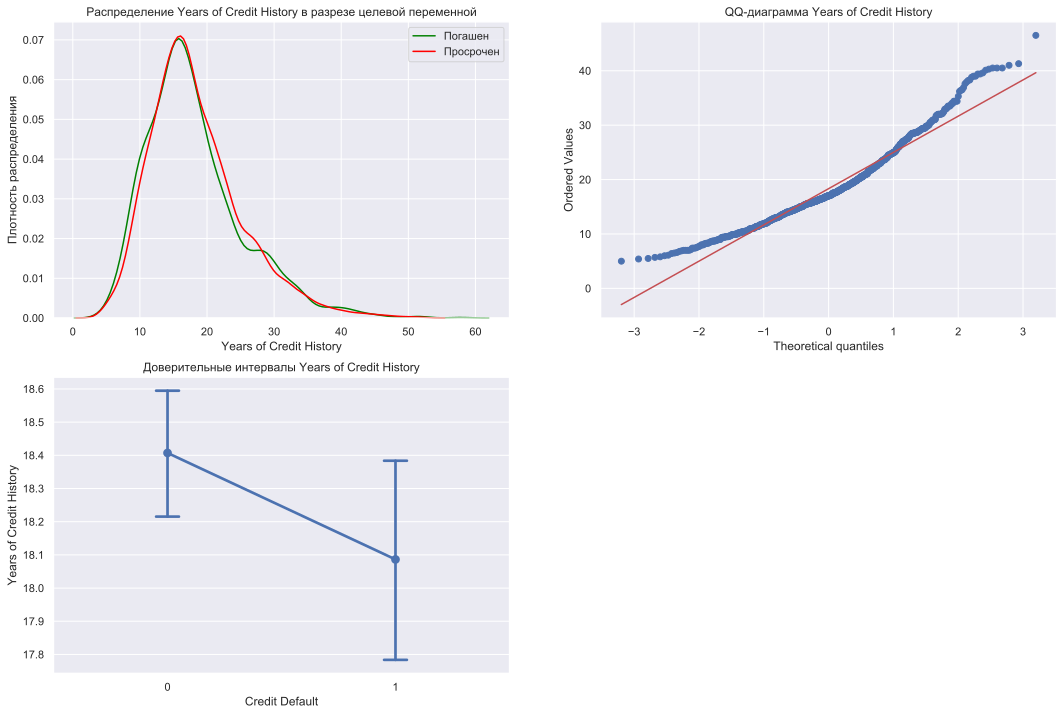

In [69]:
plot_kde_qq_interval(train_df, 'Years of Credit History')

Распределение далеко от нормального + распредедения в разрезе целевой переменной очень схожи, доверительные интервалы находятся в непосредственной близости. Возможно признак является плохим для построения модели. Посмотрим на Шапиро-Уилка

In [70]:
shapiro_samples(train_df,'Years of Credit History', 30, bxc=True)

Среднее P-value по Shapiro с обратным преобразованием: 0.2754942060293009
Среднее P-value по Shapiro без обратного преобразования: 1.8983642276088685e-16
Установленный нами порог α = 0,05


Я делал признак, преобразованный по Боксу-Коксу - он не подходит. 

Помимо этого он каким-то образом добавлял 3 строчки в датасет, в следствие чего моя функция для Хи-квадрат ломалась

In [71]:
manna_uitny(train_df, 'Years of Credit History', 30)

Среднее p-value по критерию Манна-Уитни равно: 0.09744208034951647
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза принимается**
* **Признак Years of Credit History BXC очень слабо полезен для построения модели**
* **Признак Years of Credit History слабо полезен**

### 4.4 Maximum Open Credit

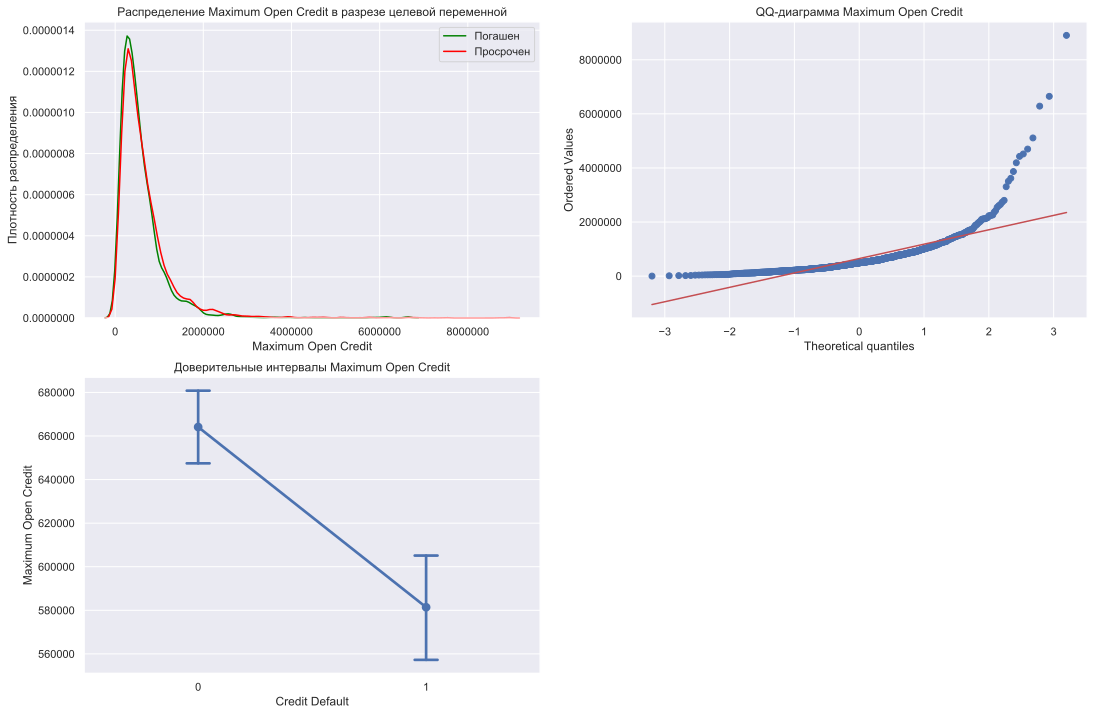

In [72]:
plot_kde_qq_interval(train_df, 'Maximum Open Credit')

Визуально распределения схожи, при этом похожи на нормальные. Интервалы говорят нам о возможной полезности признака.
Смотрим на Шапиро-Уилка
Преобразование Бокса-Кокса работает только с положительными данными, ОТЛИЧНЫМИ от нуля! А на графике видны нулевые значения признака => не используем преобразование Бокса-Кокса

In [73]:
shapiro_samples(train_df, 'Maximum Open Credit', 30)

Среднее P-value по Shapiro: 1.9940187244520479e-35
Установленный нами порог α = 0,05


Тест Шапиро-Уилка нашел эти распределения нормальными для установленного нами порога α (чего не скажешь из графика, очень странные дела), посмотрмм на t-критерий Стьюдента

In [74]:
t_student(train_df, 'Maximum Open Credit', 30)

Среднее p-value по t-критерию Стьюдента равно: 0.018904716975336543
Установленный нами порог α = 0,05


Не дотягиваем совсем чуточку, но хоть данный признак и не прошел по нашему критерию, он довольно сомнителен для построения модели

#### Выводы:
* **Нулевая гипотеза отвергается**
* **Признак Maximum Open Credit будет полезен для построения модели**

### 4.5 Current Loan Amount

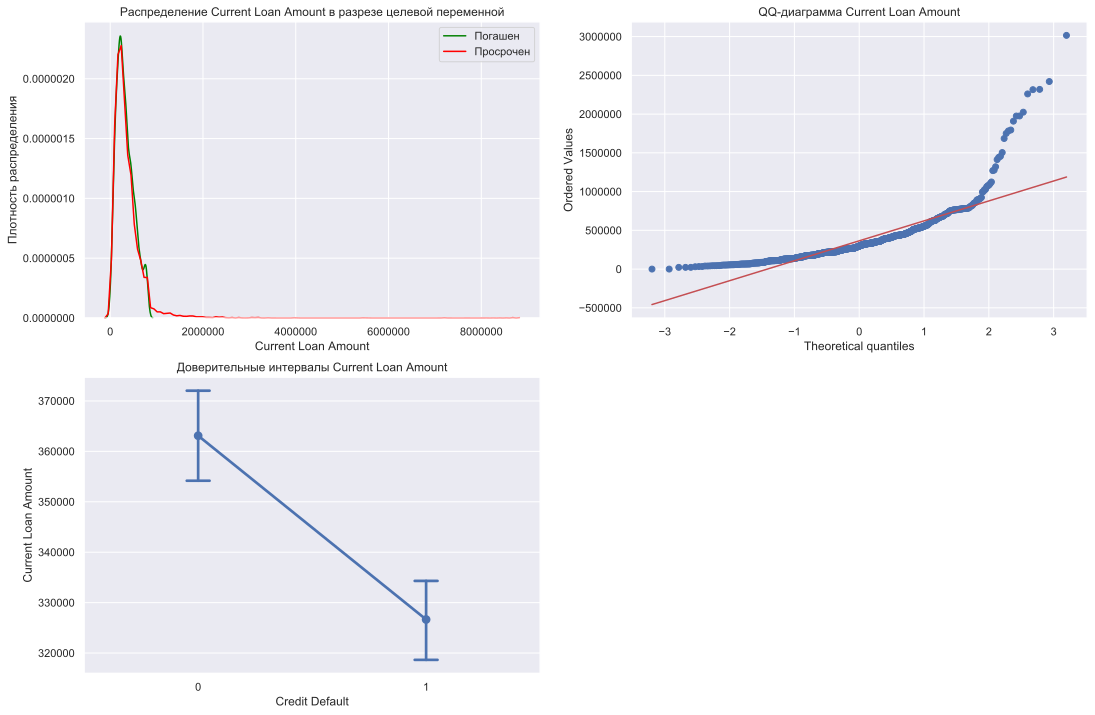

In [75]:
plot_kde_qq_interval(train_df, 'Current Loan Amount')

Визуально распределения очень похожи, но не являются нормальными. Доверительным интервалы не пересекаются.

In [76]:
shapiro_samples(train_df,'Current Loan Amount',30)

Среднее P-value по Shapiro: 8.557971895564582e-33
Установленный нами порог α = 0,05


Но критерий Шапиро-Уилка говорит нам об обратном, смотрим на t-критерий Стьюдента

In [77]:
t_student(train_df,'Current Loan Amount', 30)

Среднее p-value по t-критерию Стьюдента равно: 0.008789787298621215
Установленный нами порог α = 0,05


Ситуация как и с прошлым признаком

#### Выводы:
* **Нулевая гипотеза отвергается**
* **Признак Current Loan Amount будет полезен для построения модели**

### 4.6 Current Credit Balance

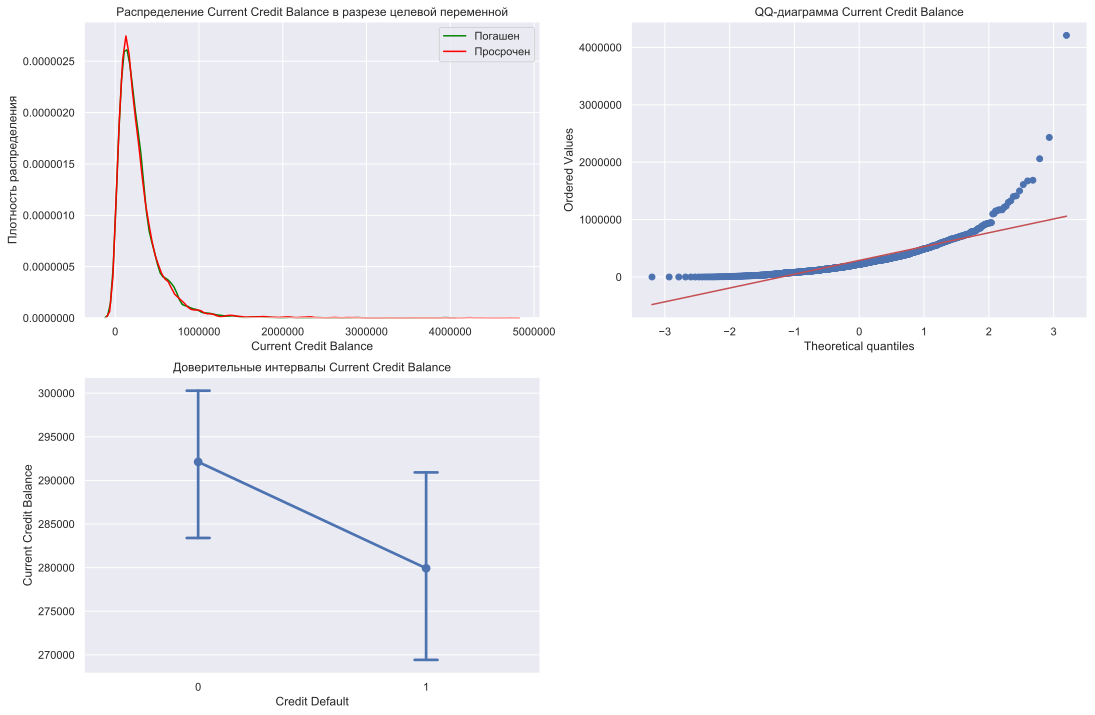

In [78]:
plot_kde_qq_interval(train_df, 'Current Credit Balance')

Распределения очень похожи, доверительные интервалы примерно на 1/2 находятся в границах друг друга. Ветроятно плохой признак. Посмотрим на критерий Шапиро-Уилка

In [79]:
shapiro_samples(train_df,'Current Credit Balance', 30)

Среднее P-value по Shapiro: 5.1999958650875936e-33
Установленный нами порог α = 0,05


t-критерий Стьюдента:

In [80]:
t_student(train_df,'Current Credit Balance',30)

Среднее p-value по t-критерию Стьюдента равно: 0.43833741153153677
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза принимается**
* **Признак Current Credit Balance не будет полезен для построения модели**

### 4.7 Monthly Debt

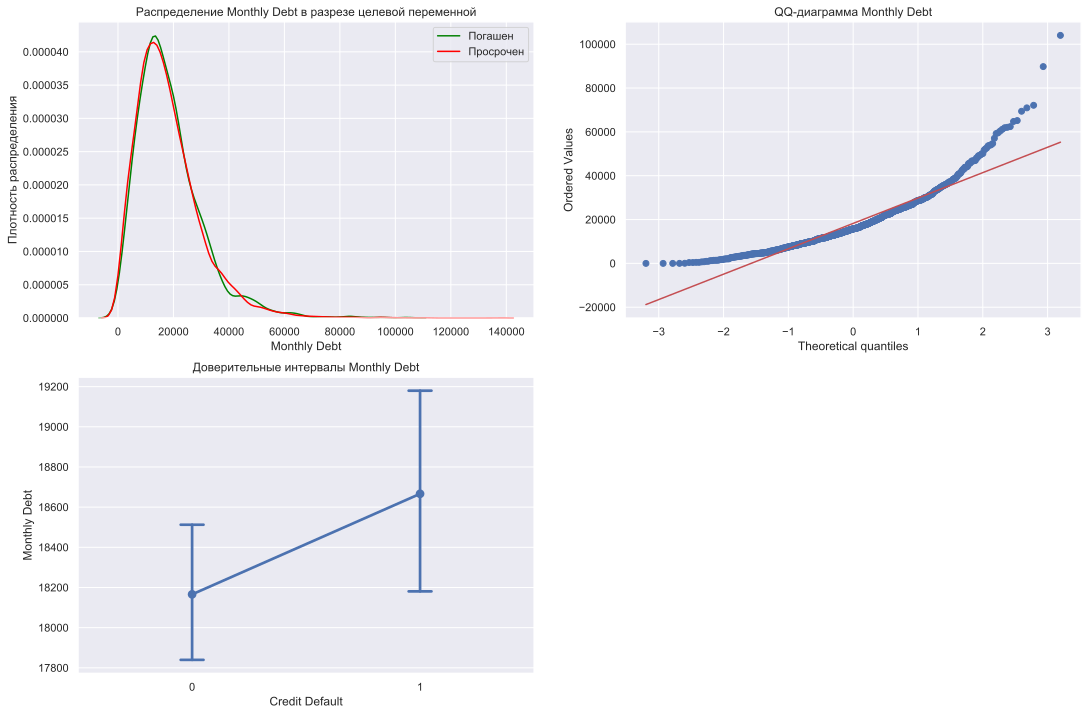

In [81]:
plot_kde_qq_interval(train_df,'Monthly Debt')

Снова очень схожие распределения, доверительные интервалы находятся в пределеах друг друга
Смотрим на Шапиро-Уилка

In [82]:
shapiro_samples(train_df,'Monthly Debt',30)

Среднее P-value по Shapiro: 5.854356601054415e-22
Установленный нами порог α = 0,05


In [83]:
t_student(train_df,'Monthly Debt',30)

Среднее p-value по t-критерию Стьюдента равно: 0.34179908467705994
Установленный нами порог α = 0,05


#### Выводы:
* **Нулевая гипотеза принимается**
* **Признак Monthly Debt не будет полезен для построения модели**

### 4.8 Credit Score

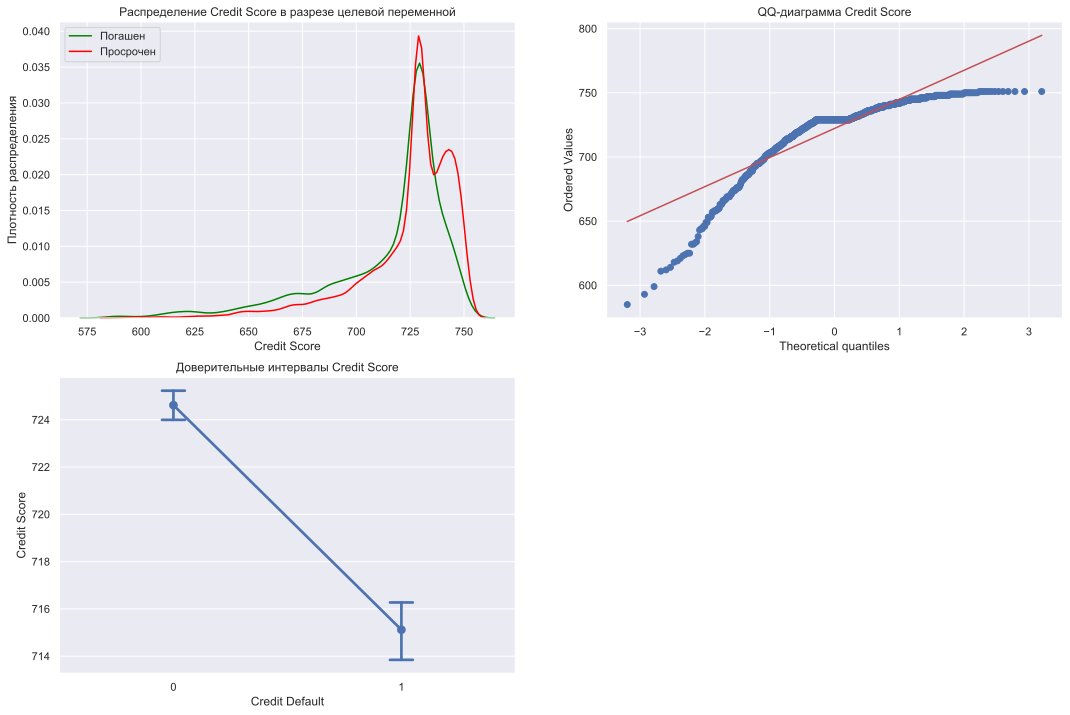

In [84]:
plot_kde_qq_interval(train_df, 'Credit Score')

Распределение очень далеко от нормального, и главное оно разное. Доверительные интервалы находятся далеко друг от друга.
Смотрим на Шапиро-Уилка

In [85]:
shapiro_samples(train_df,'Credit Score',30, bxc=True)

Среднее P-value по Shapiro с обратным преобразованием: 1.0
Среднее P-value по Shapiro без обратного преобразования: 1.8258759315679534e-32
Установленный нами порог α = 0,05


Смотрим на t-Стьюдента

In [86]:
t_student(train_df,'Credit Score',30)

Среднее p-value по t-критерию Стьюдента равно: 1.8165126474713294e-11
Установленный нами порог α = 0,05


Один из самых полезных критериев(наряду с Annual Income), что логично

#### Выводы:
* **Нулевая гипотеза отвергается**
* **Признак Credit Score очень полезен для построения модели**

### Обзор колличественных признаков по результатам анализа:
#### Признаки с наибольшим весом:
* **Annual Income**
* **Credit Score**

#### Полезные признаки:
* **Maximum Open Credit**
* **Current Loan Amount**

#### Спорные(?) признаки:
* **Number of Open Accounts**
* **Years of Credit History**
* **Current Credit Balance**
* **Monthly Debt**

### Стоит ли мне удалить спорные(плохие) признаки, или лучше смотреть на результаты модели поочередно удаляя эти признаки?

## 5 Подробный анализ категориальных данных 

* **Нулевая гипотеза H0** - частоты согласованы
* **Альтернативная гипотеза H1** - отклонения в частотах сильно различаются
* **Критерии** - Хи-квадрат Пирсона
* **Порог α** - 0,05

### 5.1 Home Ownership

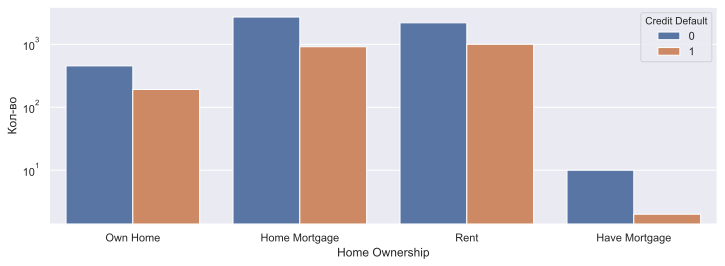

In [87]:
cat_plot(train_df,'Home Ownership', x=True, log_y=True)

Исходя из графика можно предположить, что все категории имеют похожее частотное распределение в разрезе целелвой переменной.
Проверим предположение с помощью критерия Пирсона

In [88]:
chi2_cat_to_cat(train_df, 'Home Ownership', 30, all_info = True)

Own Home    -    Home Mortgage
Среднее chi2 равно: 1.1128738703058425
Среднее p-value равно: 0.4722869214250916
Установленный нами порог α = 0,05
-------------------------------------------
Own Home    -    Rent
Среднее chi2 равно: 0.6077720152984083
Среднее p-value равно: 0.5482227388308217
Установленный нами порог α = 0,05
-------------------------------------------
Own Home    -    Have Mortgage
Среднее chi2 равно: 0.5690133057432419
Среднее p-value равно: 0.5393469765095563
Установленный нами порог α = 0,05
-------------------------------------------
Home Mortgage    -    Own Home
Среднее chi2 равно: 1.3755636701335119
Среднее p-value равно: 0.47068806741584673
Установленный нами порог α = 0,05
-------------------------------------------
Home Mortgage    -    Rent
Среднее chi2 равно: 3.3383174614890128
Среднее p-value равно: 0.3234945610189067
Установленный нами порог α = 0,05
-------------------------------------------
Home Mortgage    -    Have Mortgage
Среднее chi2 равно: 0.3899

#### Выводы:
* **Нулевая гипотеза принимается для Own Home, Home Mortgage, Rent**
* **Нулевая гипотеза сомнительна применима для Have Mortgage**

### 5.2 Years in current job

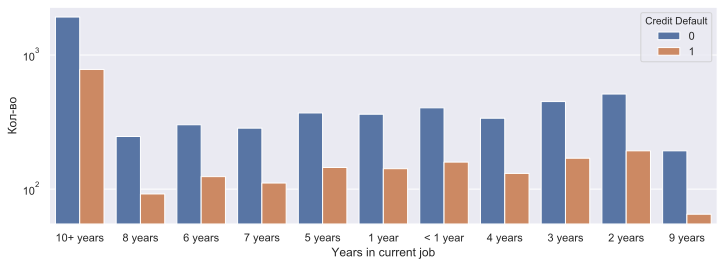

In [89]:
cat_plot(train_df,'Years in current job', x=True, log_y=True)

Определенно есть категории, частоты которых совпадают и их можно будет объединить.
Посмотрим, что покажет критерий Пирсона.

P.S. Там будет большой список, я все опишу в выводах по признаку

In [90]:
chi2_cat_to_cat(train_df,'Years in current job',30, all_info = True)

10+ years    -    8 years
Среднее chi2 равно: 0.8035282491611235
Среднее p-value равно: 0.5581470989026196
Установленный нами порог α = 0,05
-------------------------------------------
10+ years    -    6 years
Среднее chi2 равно: 0.7646169101842386
Среднее p-value равно: 0.5777415994751163
Установленный нами порог α = 0,05
-------------------------------------------
10+ years    -    7 years
Среднее chi2 равно: 0.8176389356597452
Среднее p-value равно: 0.5515922917054635
Установленный нами порог α = 0,05
-------------------------------------------
10+ years    -    5 years
Среднее chi2 равно: 0.7058399288341389
Среднее p-value равно: 0.5073299326505677
Установленный нами порог α = 0,05
-------------------------------------------
10+ years    -    1 year
Среднее chi2 равно: 0.5626553577155768
Среднее p-value равно: 0.5762162303556484
Установленный нами порог α = 0,05
-------------------------------------------
10+ years    -    < 1 year
Среднее chi2 равно: 0.8151689955245555
Среднее p-

5 years    -    < 1 year
Среднее chi2 равно: 0.5604003864967015
Среднее p-value равно: 0.6230107968951027
Установленный нами порог α = 0,05
-------------------------------------------
5 years    -    4 years
Среднее chi2 равно: 0.6201600267201991
Среднее p-value равно: 0.5462870715942263
Установленный нами порог α = 0,05
-------------------------------------------
5 years    -    3 years
Среднее chi2 равно: 0.44517024758581286
Среднее p-value равно: 0.6162920103533824
Установленный нами порог α = 0,05
-------------------------------------------
5 years    -    2 years
Среднее chi2 равно: 0.9938119013143931
Среднее p-value равно: 0.4971756161616566
Установленный нами порог α = 0,05
-------------------------------------------
5 years    -    9 years
Среднее chi2 равно: 0.8666548779305483
Среднее p-value равно: 0.48530518965665287
Установленный нами порог α = 0,05
-------------------------------------------
1 year    -    10+ years
Среднее chi2 равно: 0.6527926589361894
Среднее p-value ра

2 years    -    10+ years
Среднее chi2 равно: 0.5957001711253127
Среднее p-value равно: 0.5759247551306033
Установленный нами порог α = 0,05
-------------------------------------------
2 years    -    8 years
Среднее chi2 равно: 0.8086242585683316
Среднее p-value равно: 0.48629347482626595
Установленный нами порог α = 0,05
-------------------------------------------
2 years    -    6 years
Среднее chi2 равно: 0.9128348515795203
Среднее p-value равно: 0.4903626442909861
Установленный нами порог α = 0,05
-------------------------------------------
2 years    -    7 years
Среднее chi2 равно: 0.7878674502658582
Среднее p-value равно: 0.48351895637832326
Установленный нами порог α = 0,05
-------------------------------------------
2 years    -    5 years
Среднее chi2 равно: 0.3906381008235983
Среднее p-value равно: 0.6218490017961048
Установленный нами порог α = 0,05
-------------------------------------------
2 years    -    1 year
Среднее chi2 равно: 0.857440879741896
Среднее p-value равн

Удивительно, но

9 years    -    10+ years

Среднее chi2 равно: 1.0703448634117891

Среднее p-value равно: 0.4733160495111168

Установленный нами порог α = 0,05

Чего не скажешь по графику. Может я где-то ошибся в функции?

#### Выводы:
* **Нулевая гипотеза принимается для всех категорий**
* **Альтернативная гипотеза отвергается**

### 5.3 Purpose

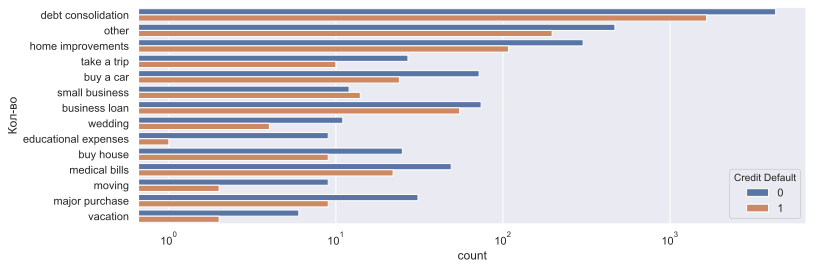

In [91]:
cat_plot(train_df,'Purpose', y = True, log_x = True)

In [92]:
# interest_info выводит данные только тех пар, где chi2 < 0.05
chi2_cat_to_cat(train_df,'Purpose',30, interest_info = True)

-------------------------------------------
debt consolidation    -    other
-------------------------------------------
debt consolidation    -    home improvements
-------------------------------------------
debt consolidation    -    take a trip
-------------------------------------------
debt consolidation    -    buy a car
-------------------------------------------
debt consolidation    -    small business
-------------------------------------------
debt consolidation    -    business loan
-------------------------------------------
debt consolidation    -    wedding
Среднее chi2 равно: 0.03608624784870791
Среднее p-value равно: 0.9610301327307066
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
debt consolidation    -    educational expenses
-------------------------------------------
debt consolidation    -    buy house
-------------------------------------------
debt consolidation    -    medical bills
--

-------------------------------------------
business loan    -    major purchase
-------------------------------------------
business loan    -    vacation
-------------------------------------------
wedding    -    debt consolidation
-------------------------------------------
wedding    -    other
-------------------------------------------
wedding    -    home improvements
-------------------------------------------
wedding    -    take a trip
Среднее chi2 равно: 0.0007044638623585998
Среднее p-value равно: 0.9788252431092842
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
wedding    -    buy a car
Среднее chi2 равно: 0.019104991394148004
Среднее p-value равно: 0.8900659115889448
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
wedding    -    small business
-------------------------------------------
wedding    -    business loan
-------

-------------------------------------------
vacation    -    take a trip
Среднее chi2 равно: 0.013820638820638827
Среднее p-value равно: 0.9064153392422762
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
vacation    -    buy a car
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
vacation    -    small business
-------------------------------------------
vacation    -    business loan
-------------------------------------------
vacation    -    wedding
Среднее chi2 равно: 0.007516339869281052
Среднее p-value равно: 0.9309124983464406
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
vacation    -    educational expenses
-------------------------------------------
vacation    -    buy house
Среднее chi2 равно: 0.0072451267

Имеем такой список:
* debt consolidation    -    educational expenses
* debt consolidation    -    vacation
* home improvements    -    vacation
* take a trip    -    wedding
* take a trip    -    buy house
* take a trip    -    vacation
* buy a car    -    wedding
* buy a car    -    buy house
* buy a car    -    vacation
* wedding    -    take a trip
* wedding    -    buy a car
* wedding    -    buy house
* wedding    -    vacation
* educational expenses    -    debt consolidation
* buy house    -    take a trip
* buy house    -    buy a car
* buy house    -    wedding
* buy house    -    vacation
* major purchase    -    vacation
* vacation    -    debt consolidation
* vacation    -    home improvements
* vacation    -    take a trip
* vacation    -    buy a car
* vacation    -    wedding
* vacation    -    buy house
* vacation    -    major purchase


После разбора сложилось мнение, что этот признак можно разделить на 3 бинарных:
#### 1:
* debt consolidation
* other
* home improvements
* take a trip
* buy a car
* small business
* business loan
* medical bills
* major purchase

#### 2:
* vacation
* educational expenses
* moving
* buy house 

#### 3:
* Wedding

#### Выводы:
* **Нулевая гипотеза принимается для категорий по 3м бинарным признакам(списки выше)**
* **Альтернативная гипотеза отвергается**

### 5.4 Term

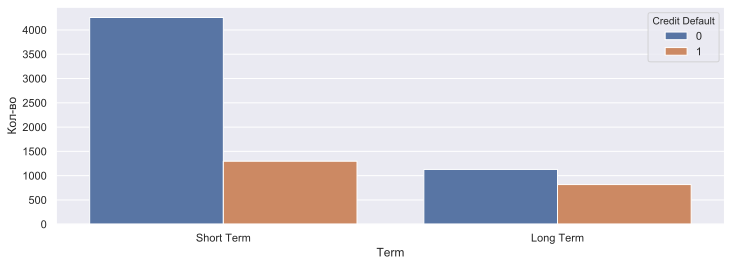

In [93]:
cat_plot(train_df,'Term',x = True)

In [94]:
chi2_cat_to_cat(train_df,'Term',30, all_info = True)

Short Term    -    Long Term
Среднее chi2 равно: 15.374336644462575
Среднее p-value равно: 0.004985313666568968
Установленный нами порог α = 0,05
-------------------------------------------
Long Term    -    Short Term
Среднее chi2 равно: 13.022456006363932
Среднее p-value равно: 0.021533425652002846
Установленный нами порог α = 0,05
-------------------------------------------


#### Выводы:
* **Нулевая гипотеза принимается**
* **Альтернативная гипотеза отвергается**
* **Признак не выглядит полезным для модели**

### 5.5 Tax Liens

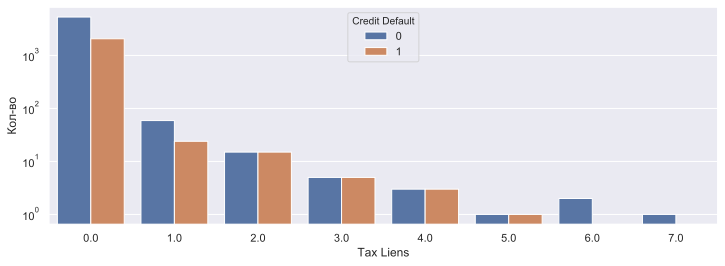

In [95]:
cat_plot(train_df,'Tax Liens', x = True, log_y = True)

In [96]:
chi2_cat_to_cat(train_df,'Tax Liens',30, interest_info=True)

-------------------------------------------
0.0    -    3.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
0.0    -    1.0
-------------------------------------------
0.0    -    2.0
-------------------------------------------
0.0    -    4.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
0.0    -    6.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
0.0    -    5.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
-------------------------------------------
0.0    -    7.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный

Не хватает данных для полной уверенности в оценке данного признака, может быть есть смысл преобразовать 0-5 и 6-7 в 2 бинарных признака?

Также логика мне подсказывает, что признак довольно важен, что мы видим по p-value, склоняюсь к разделению на 2 бинарных признака

#### Выводы:
* **Нулевая гипотеза принимается для критериев 0-5**
* **Альтернативная гипотеза принимается для критериев 6-7**
* **В целом признак не выглядит полезным для модели**

### 5.6 Number of Credit Problems

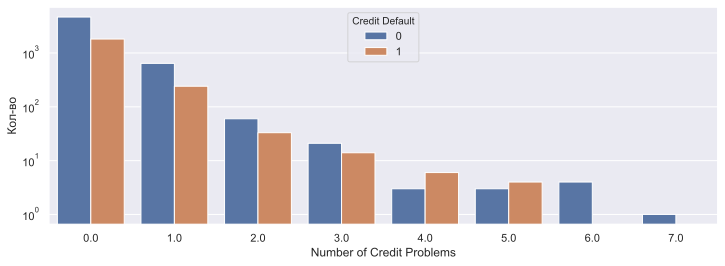

In [98]:
cat_plot(train_df,'Number of Credit Problems',x = True, log_y=True)

In [99]:
chi2_cat_to_cat(train_df,'Number of Credit Problems', 30, all_info = True)

1.0    -    0.0
Среднее chi2 равно: 1.185037033985678
Среднее p-value равно: 0.49535468986867276
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -    3.0
Среднее chi2 равно: 2.002958139203787
Среднее p-value равно: 0.29543831117767155
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -    2.0
Среднее chi2 равно: 2.1114519885362584
Среднее p-value равно: 0.38567200253153605
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -    6.0
Среднее chi2 равно: 0.0
Среднее p-value равно: 1.0
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -    4.0
Среднее chi2 равно: 2.9794043551274307
Среднее p-value равно: 0.28225562181545666
Установленный нами порог α = 0,05
-------------------------------------------
1.0    -    5.0
Среднее chi2 равно: 1.5988521354580605
Среднее p-value равно: 0.4284579483350556
Установленный нами порог α = 0,05
----------------------

Тут все по такой же схеме, как в предыдущем

## Мои Вопросы:
* **Общее мнение по поводу колличественных данных? Стоит ли удалять малозначимые признаки или сначала посмотреть на поведение модели?**
* **
* **Общее мнение по поводу категориальных данных? Стоит ли объединять признаки в связи с показаниями критерия Пирса и моими рассуждениями на этот счет(иными словами - правильно ли я рассуждаю)?**
* **
* **Объединенные категориальные признаки представить как дамми переменные?**
* **
* **Тестовый датасет тоже подвергать подробному анализу на распределение? Если да, то я не совсем понимаю зачем, ведь в тестовом датасете должны быть признаки, идентичные тренировочным. А наиболее/наименее полезные мы уже выявили и тренировать модель будем на определенных признаках. Подробный анализ тестового датасета уже не важен. Я прав?**

## Преобразование категориальных данных в бинарные

In [69]:
colls = train_df.select_dtypes('object').columns.to_list()
train_final = pd.get_dummies(train_df,columns = colls)
train_final.head()

Annual Income  Tax Liens  Number of Open Accounts  Years of Credit History  \
0       482087.0        0.0                     11.0                     26.3   
1      1025487.0        0.0                     15.0                     15.3   
2       751412.0        0.0                     11.0                     35.0   
3       805068.0        0.0                      8.0                     22.5   
4       776264.0        0.0                     13.0                     13.6   

   Maximum Open Credit  Number of Credit Problems  Bankruptcies  \
0             685960.0                        1.0           1.0   
1            1181730.0                        0.0           0.0   
2            1182434.0                        0.0           0.0   
3             147400.0                        1.0           1.0   
4             385836.0                        1.0           0.0   

   Current Loan Amount  Current Credit Balance  Monthly Debt  ...  \
0             685960.0                 47386.0        7914.0  ...   
1             264968.0                394972.0       18373.0  ...   
2            1182434.0                308389.0       13651.0  ...   
3             121396.0                 95855.0       11338.0  ...   
4             125840.0                 93309.0        7180.0  ...   

   Purpose_major purchase  Purpose_medical bills  Purpose_moving  \
0                       0                      0               0   
1                       0                      0               0   
2                       0                      0               0   
3                       0                      0               0   
4                       0                      0               0   

   Purpose_other  Purpose_small business  Purpose_take a trip  \
0              0                       0                    0   
1              0                       0                    0   
2              0                       0                    0   
3              0                       0                    0   
4              0                       0                    0   

   Purpose_vacation  Purpose_wedding  Term_Long Term  Term_Short Term  
0                 0                0               0                1  
1                 0                0               1                0  
2                 0                0               0                1  
3                 0                0               0                1  
4                 0                0               0                1  

[5 rows x 44 columns]

## Приведение типов

In [70]:
dig_colls = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
         'Maximum Open Credit','Number of Credit Problems','Bankruptcies','Current Loan Amount',
        'Current Credit Balance','Monthly Debt','Credit Score']
for dig_col in dig_colls:
    train_final[dig_col] = train_final[dig_col].astype('int64')

"""cat_colls = train_final.select_dtypes('uint8').columns.to_list()
for cat_col in cat_colls:
    train_final[cat_col] = train_final[cat_col].astype('str')"""


"cat_colls = train_final.select_dtypes('uint8').columns.to_list()\nfor cat_col in cat_colls:\n    train_final[cat_col] = train_final[cat_col].astype('str')"

In [65]:
#train_target = train_final['Credit Default']
#train_final = train_final.drop('Credit Default', axis = 1)